# Hiking Speed Analysis & Prediction

This notebook analyzes your hiking tracks from GaiaGPS to build a personalized speed prediction model that accounts for:
- Terrain slope (uphill/downhill)
- Fatigue over the day
- Your specific knee problems affecting descents

## Setup Instructions

1. Export your tracks from GaiaGPS as GPX files:
   - Go to gaiagps.com/map
   - Select each track from last year
   - Click "Export" and choose GPX format
   - Save all GPX files in a folder called `gaiagps_tracks/`

2. Install required packages (run the cell below)

In [1]:
# Install required packages
!pip install gpxpy numpy pandas matplotlib scikit-learn seaborn geopy


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import gpxpy
import gpxpy.gpx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
from geopy.distance import geodesic
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Parse GPX Files

In [3]:
def parse_gpx_file(gpx_file_path, file_type='track'):
    """
    Parse a GPX file and extract points with coordinates, elevation, and timestamps.
    
    Args:
        gpx_file_path: Path to the GPX file
        file_type: 'track' for recorded tracks (with timestamps),
                   'route' for planned routes (without timestamps)
    
    Returns:
        DataFrame with point data
    """
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    
    points = []
    
    if file_type == 'track':
        # Parse track points (recorded GPS data with timestamps)
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points.append({
                        'latitude': point.latitude,
                        'longitude': point.longitude,
                        'elevation': point.elevation,
                        'time': point.time,
                        'track_name': track.name or gpx_file_path.stem
                    })
    elif file_type == 'route':
        # Parse route points (planned routes, cleaner elevation from map)
        for route in gpx.routes:
            for point in route.points:
                points.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'time': None,  # Routes don't have timestamps
                    'route_name': route.name or gpx_file_path.stem
                })
    
    return pd.DataFrame(points)


def load_all_routes(routes_folder='gaiagps_routes'):
    """
    Load all route GPX files from the specified folder.
    Routes are planned paths with clean elevation data from maps.
    """
    routes_path = Path(routes_folder)
    
    if not routes_path.exists():
        print(f"Creating folder: {routes_folder}")
        routes_path.mkdir(parents=True, exist_ok=True)
        print(f"Please add your route GPX files to the '{routes_folder}' folder.")
        return None
    
    gpx_files = list(routes_path.glob('*.gpx'))
    
    if not gpx_files:
        print(f"No GPX files found in '{routes_folder}' folder.")
        return None
    
    print(f"Found {len(gpx_files)} route GPX files:")
    for gpx_file in gpx_files:
        print(f"  - {gpx_file.name}")
    
    all_routes = []
    for gpx_file in gpx_files:
        try:
            df = parse_gpx_file(gpx_file, file_type='route')
            if len(df) > 0:
                df['file_name'] = gpx_file.name
                all_routes.append(df)
                print(f"✓ Loaded {gpx_file.name}: {len(df)} points")
            else:
                print(f"⚠ {gpx_file.name}: No route data found")
        except Exception as e:
            print(f"✗ Error loading {gpx_file.name}: {e}")
    
    if not all_routes:
        return None
    
    combined_df = pd.concat(all_routes, ignore_index=True)
    print(f"\nTotal route points loaded: {len(combined_df)}")
    return combined_df


def load_all_tracks(tracks_folder='gaiagps_tracks'):
    """
    Load all GPX files from the specified folder.
    """
    tracks_path = Path(tracks_folder)
    
    if not tracks_path.exists():
        print(f"Creating folder: {tracks_folder}")
        tracks_path.mkdir(parents=True, exist_ok=True)
        print(f"Please add your GPX files to the '{tracks_folder}' folder and re-run this cell.")
        return None
    
    gpx_files = list(tracks_path.glob('*.gpx'))
    
    if not gpx_files:
        print(f"No GPX files found in '{tracks_folder}' folder.")
        print("Please export your tracks from GaiaGPS and save them in this folder.")
        return None
    
    print(f"Found {len(gpx_files)} GPX files:")
    for gpx_file in gpx_files:
        print(f"  - {gpx_file.name}")
    
    all_tracks = []
    for gpx_file in gpx_files:
        try:
            df = parse_gpx_file(gpx_file, file_type='track')
            df['file_name'] = gpx_file.name
            all_tracks.append(df)
            print(f"✓ Loaded {gpx_file.name}: {len(df)} points")
        except Exception as e:
            print(f"✗ Error loading {gpx_file.name}: {e}")
    
    if not all_tracks:
        return None
    
    combined_df = pd.concat(all_tracks, ignore_index=True)
    combined_df = combined_df.sort_values('time').reset_index(drop=True)
    
    print(f"\nTotal points loaded: {len(combined_df)}")
    return combined_df


# Load tracks
tracks_df = load_all_tracks()

if tracks_df is not None:
    print("\nFirst few points:")
    display(tracks_df.head())

Found 2 GPX files:
  - rando-mont-gorille.gpx
  - rando-corbeau-ouareau.gpx
✓ Loaded rando-mont-gorille.gpx: 2944 points
✓ Loaded rando-corbeau-ouareau.gpx: 3527 points

Total points loaded: 6471

First few points:


,latitude,longitude,elevation,time,track_name,file_name
0,46.223719,-74.046854,397.2,2025-08-23 13:02:42+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
1,46.223748,-74.046870,400.0,2025-08-23 13:14:44+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
2,46.223864,-74.046860,399.0,2025-08-23 13:14:52+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
3,46.223926,-74.046822,400.0,2025-08-23 13:14:58+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx
4,46.223943,-74.046786,400.0,2025-08-23 13:14:59+00:00,Rando corbeau ouareau,rando-corbeau-ouareau.gpx


## 2. Calculate Hiking Metrics

For each segment between consecutive points, we'll calculate:
- Distance traveled
- Elevation change
- Slope (gradient)
- Time elapsed
- Speed
- Cumulative hiking time for the day

In [4]:
def filter_long_breaks(df, break_threshold_minutes=60):
    """
    Remove LONG breaks only (lunch, camping) while preserving short pauses.
    
    Short pauses (water, breath, photos < 60 minutes) are PART OF HIKING and should
    be included in the model. Only remove gaps that indicate lunch or end-of-day.
    
    Args:
        df: DataFrame with GPS points (must have time column)
        break_threshold_minutes: Time gap to consider a "long break" (default: 60 min)
    
    Returns:
        DataFrame with long breaks removed but short pauses preserved
    """
    if df is None or len(df) < 2:
        return df
    
    df = df.copy().sort_values('time').reset_index(drop=True)
    break_threshold = timedelta(minutes=break_threshold_minutes)
    
    # Mark points to keep
    keep_mask = np.ones(len(df), dtype=bool)
    
    # Process each track separately
    for track_name in df['track_name'].unique():
        track_mask = df['track_name'] == track_name
        track_indices = np.where(track_mask)[0]
        
        for i in range(len(track_indices) - 1):
            idx1 = track_indices[i]
            idx2 = track_indices[i + 1]
            
            time_gap = df.iloc[idx2]['time'] - df.iloc[idx1]['time']
            
            # If gap is longer than threshold, mark the first point of the gap for removal
            # This will cause calculate_hiking_metrics to restart cumulative time
            if time_gap > break_threshold:
                keep_mask[idx1] = False
    
    filtered_df = df[keep_mask].reset_index(drop=True)
    
    removed_count = len(df) - len(filtered_df)
    
    # Detailed break analysis
    breaks_found = []
    for track_name in df["track_name"].unique():
        track_mask = df["track_name"] == track_name
        track_indices = np.where(track_mask)[0]
        
        for k in range(len(track_indices) - 1):
            idx1 = track_indices[k]
            idx2 = track_indices[k + 1]
            
            time_gap = df.iloc[idx2]["time"] - df.iloc[idx1]["time"]
            
            if time_gap > break_threshold:
                breaks_found.append({
                    "track": track_name,
                    "gap_minutes": time_gap.total_seconds() / 60,
                    "time_before": df.iloc[idx1]["time"],
                    "time_after": df.iloc[idx2]["time"]
                })
    
    removed_pct = (removed_count / len(df)) * 100
    print(f"Long break filter: Removed {removed_count} points ({removed_pct:.1f}%) marking breaks >{break_threshold_minutes}min")
    print(f"  Found {len(breaks_found)} breaks longer than {break_threshold_minutes} minutes:")
    for brk in breaks_found:
        print(f"    - {brk['track']}: {brk['gap_minutes']:.1f} min gap at {brk['time_before'].strftime('%Y-%m-%d %H:%M:%S')}")
    
    
    return filtered_df


def smooth_elevation(df, window_distance_m=100):
    """
    Smooth elevation data using a distance-based moving average to reduce GPS noise.
    
    GPS altitude can have ±5-10m errors, creating false slope variations.
    This smooths elevation over a specified distance window.
    
    Args:
        df: DataFrame with GPS points (must have latitude, longitude, elevation)
        window_distance_m: Distance window for smoothing (default: 100m)
    
    Returns:
        DataFrame with smoothed elevation in 'elevation_smoothed' column
    """
    if df is None or len(df) < 2:
        return df
    
    df = df.copy()
    
    # Process each track separately
    for track_name in df['track_name'].unique():
        track_mask = df['track_name'] == track_name
        track_indices = df[track_mask].index
        
        # Calculate cumulative distance for this track
        distances = [0]
        for i in range(len(track_indices) - 1):
            idx1 = track_indices[i]
            idx2 = track_indices[i + 1]
            coord1 = (df.loc[idx1, 'latitude'], df.loc[idx1, 'longitude'])
            coord2 = (df.loc[idx2, 'latitude'], df.loc[idx2, 'longitude'])
            dist = geodesic(coord1, coord2).meters
            distances.append(distances[-1] + dist)
        
        # Smooth elevation using distance-weighted moving average
        smoothed_elevations = []
        for i, idx in enumerate(track_indices):
            current_dist = distances[i]
            
            # Find points within the distance window
            weights = []
            elevations = []
            
            for j, idx2 in enumerate(track_indices):
                dist_diff = abs(distances[j] - current_dist)
                if dist_diff <= window_distance_m:
                    # Gaussian-like weighting: closer points have more weight
                    weight = np.exp(-(dist_diff**2) / (2 * (window_distance_m/3)**2))
                    weights.append(weight)
                    elevations.append(df.loc[idx2, 'elevation'])
            
            # Calculate weighted average
            if weights:
                smoothed_elev = np.average(elevations, weights=weights)
            else:
                smoothed_elev = df.loc[idx, 'elevation']
            
            smoothed_elevations.append(smoothed_elev)
        
        # Update the dataframe
        df.loc[track_indices, 'elevation_smoothed'] = smoothed_elevations
    
    # Calculate improvement
    if 'elevation' in df.columns and 'elevation_smoothed' in df.columns:
        elev_changes = df.groupby('track_name').apply(
            lambda x: abs(x['elevation'].diff()).sum()
        )
        smooth_changes = df.groupby('track_name').apply(
            lambda x: abs(x['elevation_smoothed'].diff()).sum()
        )
        reduction_pct = ((elev_changes - smooth_changes) / elev_changes * 100).mean()
        print(f"Elevation smoothing ({window_distance_m}m window): Reduced noise by {reduction_pct:.1f}%")
    
    return df


def calculate_hiking_metrics_with_pauses(df, slope_window_distance_m=100):
    """
    Calculate hiking metrics INCLUDING short pauses as part of normal hiking rhythm.
    
    PHILOSOPHY CHANGE: 
    - OLD: Model pure walking speed, filter out all pauses
    - NEW: Model realistic hiking speed including short breaks (water, breath)
    
    This produces more accurate predictions for total hiking time because short pauses
    are a natural part of the hiking activity, especially as fatigue increases.
    
    Args:
        df: DataFrame with GPS points
        slope_window_distance_m: Distance over which to calculate slope (default: 100m)
    """
    if df is None or len(df) < 2:
        return None
    
    metrics = []
    
    # Group by track to process each hike separately
    for track_name in df['track_name'].unique():
        track_df = df[df['track_name'] == track_name].copy()
        track_df = track_df.sort_values('time').reset_index(drop=True)
        
        # Calculate cumulative distance for slope calculation
        track_df['cumulative_distance_m'] = 0.0
        for i in range(1, len(track_df)):
            coord1 = (track_df.iloc[i-1]['latitude'], track_df.iloc[i-1]['longitude'])
            coord2 = (track_df.iloc[i]['latitude'], track_df.iloc[i]['longitude'])
            dist = geodesic(coord1, coord2).meters
            track_df.loc[i, 'cumulative_distance_m'] = track_df.loc[i-1, 'cumulative_distance_m'] + dist
        
        current_day_start = None
        cumulative_time_hours = 0
        
        for i in range(len(track_df) - 1):
            p1 = track_df.iloc[i]
            p2 = track_df.iloc[i + 1]
            
            # Calculate distance
            coord1 = (p1['latitude'], p1['longitude'])
            coord2 = (p2['latitude'], p2['longitude'])
            distance_m = geodesic(coord1, coord2).meters
            
            # Calculate time elapsed
            time_delta = (p2['time'] - p1['time']).total_seconds()
            
            # CHANGED: More lenient filtering - keep short pauses
            
            # Filter 1: Reset day on very long breaks (>60 min = lunch/camp)
            if time_delta > 3600:  # 60 minutes
                current_day_start = p2['time']
                cumulative_time_hours = 0
                continue
            
            # Filter 2: Remove only obvious GPS errors (stationary for >5 min with no movement)
            if time_delta > 300 and distance_m < 5:  # 5 minutes, <5m
                continue
            
            # Filter 3: Skip if points are too close (GPS noise)
            if distance_m < 1:
                continue
            
            # Calculate speed
            if time_delta > 0:
                speed_ms = distance_m / time_delta
                speed_kmh = speed_ms * 3.6
            else:
                continue
            
            # Filter 4: Skip unrealistic speeds (> 15 km/h for hiking)
            if speed_kmh > 15:
                continue
            
            # Calculate slope over a longer distance window
            current_dist = p1['cumulative_distance_m']
            half_window = slope_window_distance_m / 2
            
            # Find point behind
            back_idx = i
            for j in range(i - 1, -1, -1):
                if current_dist - track_df.iloc[j]['cumulative_distance_m'] >= half_window:
                    back_idx = j
                    break
            
            # Find point ahead
            forward_idx = i
            for j in range(i + 1, len(track_df)):
                if track_df.iloc[j]['cumulative_distance_m'] - current_dist >= half_window:
                    forward_idx = j
                    break
            
            # Calculate slope over this longer segment
            if forward_idx != back_idx:
                dist_span = track_df.iloc[forward_idx]['cumulative_distance_m'] - track_df.iloc[back_idx]['cumulative_distance_m']
                elev_span = track_df.iloc[forward_idx]['elevation_smoothed'] - track_df.iloc[back_idx]['elevation_smoothed']
                slope_percent = (elev_span / dist_span * 100) if dist_span > 0 else 0
            else:
                elev_change_m = p2['elevation_smoothed'] - p1['elevation_smoothed'] if (p1['elevation_smoothed'] and p2['elevation_smoothed']) else 0
                slope_percent = (elev_change_m / distance_m * 100) if distance_m > 0 else 0
            
            # Use point-to-point elevation change
            elev_change_m = p2['elevation_smoothed'] - p1['elevation_smoothed'] if (p1['elevation_smoothed'] and p2['elevation_smoothed']) else 0
            
            # Detect day boundaries
            if current_day_start is None:
                current_day_start = p1['time']
                cumulative_time_hours = 0
            
            # Update cumulative time INCLUDING pauses (they're part of hiking!)
            cumulative_time_hours += time_delta / 3600
            
            metrics.append({
                'track_name': track_name,
                'file_name': p1['file_name'],
                'time': p1['time'],
                'date': p1['time'].date(),
                'distance_m': distance_m,
                'elevation_change_m': elev_change_m,
                'slope_percent': slope_percent,
                'time_delta_s': time_delta,
                'speed_kmh': speed_kmh,
                'speed_ms': speed_ms,
                'cumulative_hours': cumulative_time_hours,
                'latitude': p1['latitude'],
                'longitude': p1['longitude'],
                'elevation': p1['elevation_smoothed']
            })
    
    return pd.DataFrame(metrics)


# Load tracks
tracks_df = load_all_tracks()

if tracks_df is not None:
    print("\nOriginal data:")
    print(f"  Total points: {len(tracks_df)}")
    
    # Filter out LONG breaks only (>60 minutes = lunch/camping)
    print("\nFiltering long breaks (>60 min = lunch/camping)...")
    tracks_df = filter_long_breaks(tracks_df, break_threshold_minutes=60)
    
    print(f"  After filtering: {len(tracks_df)} points")
    
    # Smooth elevation data to reduce GPS noise
    print("\nSmoothing elevation data to reduce GPS noise...")
    tracks_df = smooth_elevation(tracks_df, window_distance_m=100)

# Calculate metrics - NOW INCLUDES SHORT PAUSES
if tracks_df is not None:
    print("\nCalculating hiking metrics (INCLUDING short pauses as part of hiking)...")
    hiking_metrics = calculate_hiking_metrics_with_pauses(tracks_df, slope_window_distance_m=100)
    
    if hiking_metrics is not None:
        print(f"  Final segments: {len(hiking_metrics)}")
        print(f"\nSummary statistics:")
        print(hiking_metrics[['distance_m', 'slope_percent', 'speed_kmh', 'cumulative_hours']].describe())
        
        print(f"\nNumber of hiking days: {hiking_metrics['date'].nunique()}")
        print(f"Unique tracks: {hiking_metrics['track_name'].nunique()}")
        
        # Check speed distribution
        print("\nSpeed by cumulative time:")
        for hour in range(0, int(hiking_metrics['cumulative_hours'].max()) + 1):
            subset = hiking_metrics[(hiking_metrics['cumulative_hours'] >= hour) & 
                                   (hiking_metrics['cumulative_hours'] < hour + 1)]
            if len(subset) > 0:
                print(f"  Hour {hour}-{hour+1}: {subset['speed_kmh'].mean():.2f} km/h (n={len(subset)} segments)")
        
        display(hiking_metrics.head(10))

Found 2 GPX files:
  - rando-mont-gorille.gpx
  - rando-corbeau-ouareau.gpx
✓ Loaded rando-mont-gorille.gpx: 2944 points
✓ Loaded rando-corbeau-ouareau.gpx: 3527 points

Total points loaded: 6471

Original data:
  Total points: 6471

Filtering long breaks (>60 min = lunch/camping)...
Long break filter: Removed 3 points (0.0%) marking breaks >60min
  Found 3 breaks longer than 60 minutes:
    - Rando corbeau ouareau: 1041.9 min gap at 2025-08-23 22:45:29
    - Rando Mont-Gorille: 78.7 min gap at 2025-10-30 16:28:53
    - Rando Mont-Gorille: 916.9 min gap at 2025-10-30 23:46:00
  After filtering: 6468 points

Smoothing elevation data to reduce GPS noise...
Elevation smoothing (100m window): Reduced noise by 77.5%

Calculating hiking metrics (INCLUDING short pauses as part of hiking)...
  Final segments: 6393

Summary statistics:
        distance_m  slope_percent    speed_kmh  cumulative_hours
count  6393.000000    6393.000000  6393.000000       6393.000000
mean      7.186307       0.0166

,track_name,file_name,time,date,distance_m,elevation_change_m,slope_percent,time_delta_s,speed_kmh,speed_ms,cumulative_hours,latitude,longitude,elevation
0,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:44+00:00,2025-08-23,12.917121,-0.145698,-2.117175,8.0,5.812704,1.614640,0.002222,46.223748,-74.046870,398.822874
1,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:52+00:00,2025-08-23,7.489313,-0.127375,-2.581347,6.0,4.493588,1.248219,0.003889,46.223864,-74.046860,398.677176
2,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:58+00:00,2025-08-23,3.359279,-0.069675,-2.698749,1.0,12.093405,3.359279,0.004167,46.223926,-74.046822,398.549801
3,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:14:59+00:00,2025-08-23,5.100824,-0.115458,-2.738480,3.0,6.120989,1.700275,0.005000,46.223943,-74.046786,398.480126
4,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:02+00:00,2025-08-23,8.581682,-0.224950,-2.783694,5.0,6.178811,1.716336,0.006389,46.223979,-74.046745,398.364668
5,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:07+00:00,2025-08-23,15.546901,-0.438844,-2.829897,11.0,5.088077,1.413355,0.009444,46.223974,-74.046634,398.139718
6,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:18+00:00,2025-08-23,5.685827,-0.165804,-2.643746,4.0,5.117245,1.421457,0.010556,46.223900,-74.046463,397.700874
7,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:22+00:00,2025-08-23,17.900245,-0.501285,-2.643746,12.0,5.370074,1.491687,0.013889,46.223884,-74.046393,397.535070
8,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:34+00:00,2025-08-23,3.305831,-0.089371,-3.290091,2.0,5.950496,1.652916,0.014444,46.223882,-74.046161,397.033785
9,Rando corbeau ouareau,rando-corbeau-ouareau.gpx,2025-08-23 13:15:36+00:00,2025-08-23,10.193535,-0.294137,-3.339794,21.0,1.747463,0.485406,0.020278,46.223897,-74.046124,396.944414


## 3. Exploratory Data Analysis

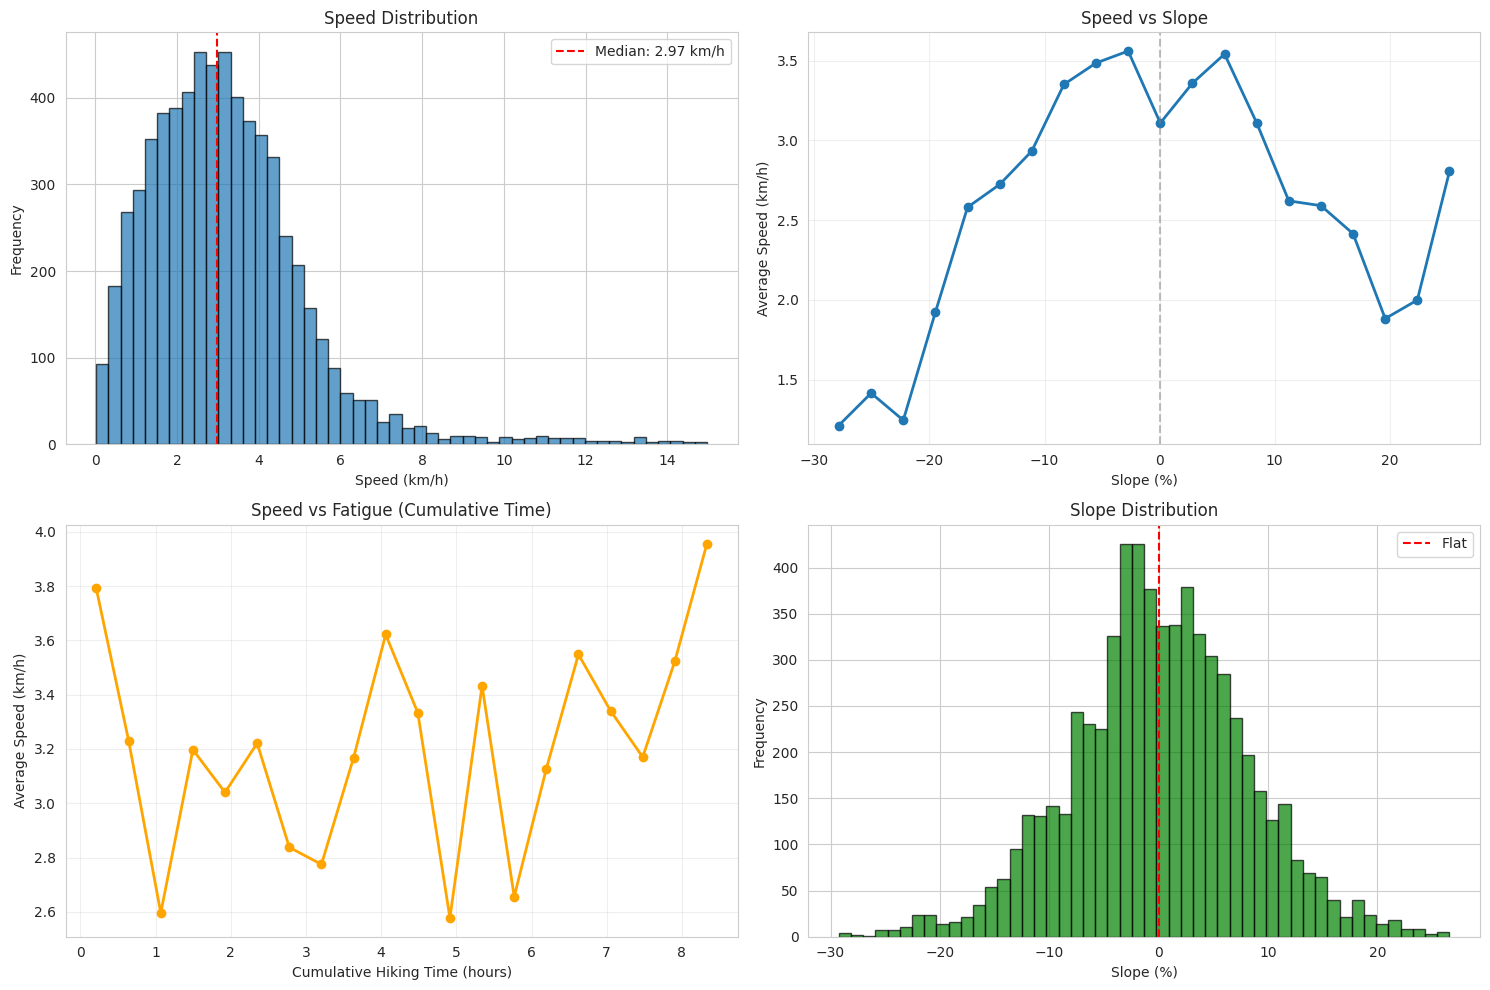

In [5]:
if hiking_metrics is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Speed distribution
    axes[0, 0].hist(hiking_metrics['speed_kmh'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Speed (km/h)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Speed Distribution')
    axes[0, 0].axvline(hiking_metrics['speed_kmh'].median(), color='red', linestyle='--', label=f'Median: {hiking_metrics["speed_kmh"].median():.2f} km/h')
    axes[0, 0].legend()
    
    # Speed vs Slope
    # Bin slope for better visualization
    slope_bins = pd.cut(hiking_metrics['slope_percent'], bins=20)
    slope_speed = hiking_metrics.groupby(slope_bins)['speed_kmh'].mean()
    slope_centers = [interval.mid for interval in slope_speed.index]
    axes[0, 1].plot(slope_centers, slope_speed.values, marker='o', linewidth=2)
    axes[0, 1].set_xlabel('Slope (%)')
    axes[0, 1].set_ylabel('Average Speed (km/h)')
    axes[0, 1].set_title('Speed vs Slope')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Speed vs Cumulative Time (fatigue effect)
    time_bins = pd.cut(hiking_metrics['cumulative_hours'], bins=20)
    time_speed = hiking_metrics.groupby(time_bins)['speed_kmh'].mean()
    time_centers = [interval.mid for interval in time_speed.index]
    axes[1, 0].plot(time_centers, time_speed.values, marker='o', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Cumulative Hiking Time (hours)')
    axes[1, 0].set_ylabel('Average Speed (km/h)')
    axes[1, 0].set_title('Speed vs Fatigue (Cumulative Time)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Slope distribution
    axes[1, 1].hist(hiking_metrics['slope_percent'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, 1].set_xlabel('Slope (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Slope Distribution')
    axes[1, 1].axvline(0, color='red', linestyle='--', label='Flat')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
# Analyze descent performance (knee problems)
if hiking_metrics is not None:
    descents = hiking_metrics[hiking_metrics['slope_percent'] < -5].copy()
    ascents = hiking_metrics[hiking_metrics['slope_percent'] > 5].copy()
    flat = hiking_metrics[abs(hiking_metrics['slope_percent']) <= 5].copy()
    
    print("Performance by terrain type:\n")
    print(f"Flat terrain (±5%):")
    print(f"  Average speed: {flat['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {flat['speed_kmh'].median():.2f} km/h\n")
    
    print(f"Ascents (>5%):")
    print(f"  Average speed: {ascents['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {ascents['speed_kmh'].median():.2f} km/h\n")
    
    print(f"Descents (<-5%):")
    print(f"  Average speed: {descents['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {descents['speed_kmh'].median():.2f} km/h\n")
    
    # Analyze descent speed degradation with fatigue
    print("Descent speed by fatigue level:\n")
    for hours in [0, 2, 4, 6, 8]:
        subset = descents[(descents['cumulative_hours'] >= hours) & (descents['cumulative_hours'] < hours + 2)]
        if len(subset) > 0:
            print(f"  {hours}-{hours+2}h: {subset['speed_kmh'].mean():.2f} km/h (n={len(subset)})")

Performance by terrain type:

Flat terrain (±5%):
  Average speed: 3.40 km/h
  Median speed: 3.19 km/h

Ascents (>5%):
  Average speed: 2.95 km/h
  Median speed: 2.73 km/h

Descents (<-5%):
  Average speed: 3.04 km/h
  Median speed: 2.81 km/h

Descent speed by fatigue level:

  0-2h: 2.83 km/h (n=535)
  2-4h: 2.76 km/h (n=452)
  4-6h: 2.86 km/h (n=173)
  6-8h: 3.30 km/h (n=199)
  8-10h: 4.22 km/h (n=184)


## 4. Build Speed Prediction Model

We'll use a Gradient Boosting model to predict speed based on:
- Slope percentage
- Cumulative hiking hours (fatigue)
- Interaction between slope and fatigue (especially for descents with knee issues)

In [7]:
def prepare_features(df):
    """
    Prepare features for the prediction model.
    """
    features_df = df.copy()
    
    # Basic features
    features_df['slope'] = features_df['slope_percent']
    features_df['fatigue'] = features_df['cumulative_hours']
    
    # Separate uphill and downhill slopes
    features_df['uphill'] = features_df['slope'].apply(lambda x: max(0, x))
    features_df['downhill'] = features_df['slope'].apply(lambda x: abs(min(0, x)))
    
    # Fatigue interaction terms (knee problems worsen with fatigue on descents)
    features_df['downhill_fatigue'] = features_df['downhill'] * features_df['fatigue']
    features_df['uphill_fatigue'] = features_df['uphill'] * features_df['fatigue']
    
    # Quadratic terms to capture non-linear effects
    features_df['slope_squared'] = features_df['slope'] ** 2
    features_df['fatigue_squared'] = features_df['fatigue'] ** 2
    
    return features_df


if hiking_metrics is not None:
    # Prepare data
    model_data = prepare_features(hiking_metrics)
    
    # Define features and target
    feature_cols = ['slope', 'fatigue', 'uphill', 'downhill', 
                    'downhill_fatigue', 'uphill_fatigue', 
                    'slope_squared', 'fatigue_squared']
    
    X = model_data[feature_cols]
    y = model_data['speed_kmh']
    
    # Split data: use 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate model
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print("Model Performance:")
    print(f"\nTraining Set:")
    print(f"  R² Score: {train_r2:.4f}")
    print(f"  MAPE: {train_mape:.2f}%")
    print(f"\nTest Set:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  MAPE: {test_mape:.2f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    display(feature_importance)
    
    # Add predictions to the dataframe
    model_data['predicted_speed_kmh'] = model.predict(X)
    model_data['prediction_error_pct'] = abs(model_data['speed_kmh'] - model_data['predicted_speed_kmh']) / model_data['speed_kmh'] * 100

Model Performance:

Training Set:
  R² Score: 0.3448
  MAPE: 84.74%

Test Set:
  R² Score: 0.1016
  MAPE: 97.56%

Feature Importance:


,feature,importance
6,slope_squared,0.222032
1,fatigue,0.220531
7,fatigue_squared,0.188477
5,uphill_fatigue,0.118871
4,downhill_fatigue,0.096011
0,slope,0.080470
2,uphill,0.040676
3,downhill,0.032933


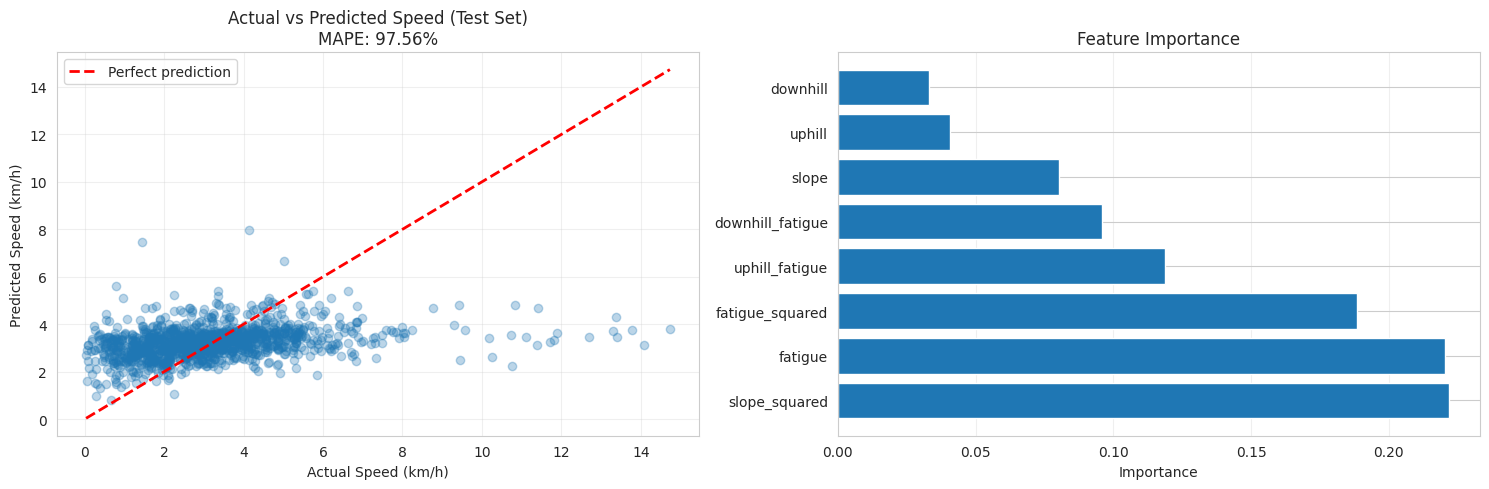

In [8]:
# Visualize model performance
if hiking_metrics is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Actual vs Predicted
    axes[0].scatter(y_test, y_pred_test, alpha=0.3)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
    axes[0].set_xlabel('Actual Speed (km/h)')
    axes[0].set_ylabel('Predicted Speed (km/h)')
    axes[0].set_title(f'Actual vs Predicted Speed (Test Set)\nMAPE: {test_mape:.2f}%')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Feature importance
    axes[1].barh(feature_importance['feature'], feature_importance['importance'])
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Feature Importance')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

## 5. Validate Model on Complete Tracks

Apply the model to entire tracks and compare predicted vs actual hiking times.

In [9]:
def validate_on_tracks(df, model, feature_cols):
    """
    Validate the model by predicting total time for each track and comparing to actual time.
    This is the OLD validation method (uses track data only).
    """
    results = []
    
    for track_name in df['track_name'].unique():
        track_data = df[df['track_name'] == track_name].copy()
        
        # Group by date to handle multi-day hikes
        for date in track_data['date'].unique():
            day_data = track_data[track_data['date'] == date].copy()
            
            # Actual metrics
            actual_time_hours = day_data['time_delta_s'].sum() / 3600
            actual_distance_km = day_data['distance_m'].sum() / 1000
            
            if actual_time_hours < 0.5:  # Skip very short segments
                continue
            
            # Predict speed for each segment
            X_pred = day_data[feature_cols]
            predicted_speeds_kmh = model.predict(X_pred)
            
            # Calculate predicted time for each segment
            day_data['predicted_time_hours'] = (day_data['distance_m'] / 1000) / predicted_speeds_kmh
            predicted_time_hours = day_data['predicted_time_hours'].sum()
            
            # Calculate error
            time_error_pct = abs(predicted_time_hours - actual_time_hours) / actual_time_hours * 100
            
            results.append({
                'track_name': track_name,
                'date': date,
                'actual_time_hours': actual_time_hours,
                'predicted_time_hours': predicted_time_hours,
                'distance_km': actual_distance_km,
                'time_error_pct': time_error_pct,
                'elevation_gain_m': day_data[day_data['elevation_change_m'] > 0]['elevation_change_m'].sum(),
                'elevation_loss_m': abs(day_data[day_data['elevation_change_m'] < 0]['elevation_change_m'].sum())
            })
    
    return pd.DataFrame(results)


if hiking_metrics is not None:
    validation_results = validate_on_tracks(model_data, model, feature_cols)
    
    print("Track Validation Results:\n")
    display(validation_results)
    
    # Check if model meets 15% accuracy requirement
    avg_error = validation_results['time_error_pct'].mean()
    within_15pct = (validation_results['time_error_pct'] <= 15).sum()
    total_tracks = len(validation_results)
    
    print(f"\n{'='*60}")
    print(f"VALIDATION SUMMARY")
    print(f"{'='*60}")
    print(f"Average prediction error: {avg_error:.2f}%")
    print(f"Tracks within 15% accuracy: {within_15pct}/{total_tracks} ({within_15pct/total_tracks*100:.1f}%)")
    
    if avg_error <= 15:
        print(f"\n✓ Model PASSES validation (average error ≤ 15%)")
    else:
        print(f"\n✗ Model FAILS validation (average error > 15%)")
        print(f"  Consider collecting more data or adjusting model parameters.")

Track Validation Results:



,track_name,date,actual_time_hours,predicted_time_hours,distance_km,time_error_pct,elevation_gain_m,elevation_loss_m
0,Rando corbeau ouareau,2025-08-23,8.546667,6.201567,19.742634,27.438765,686.803171,616.018867
1,Rando corbeau ouareau,2025-08-24,1.799167,1.504974,4.934098,16.351629,81.797799,154.851939
2,Rando Mont-Gorille,2025-10-30,7.817500,3.962258,10.514147,49.315531,486.348084,482.439655
3,Rando Mont-Gorille,2025-10-31,4.709722,3.263893,10.751184,30.698818,319.072199,327.572757



VALIDATION SUMMARY
Average prediction error: 30.95%
Tracks within 15% accuracy: 0/4 (0.0%)

✗ Model FAILS validation (average error > 15%)
  Consider collecting more data or adjusting model parameters.


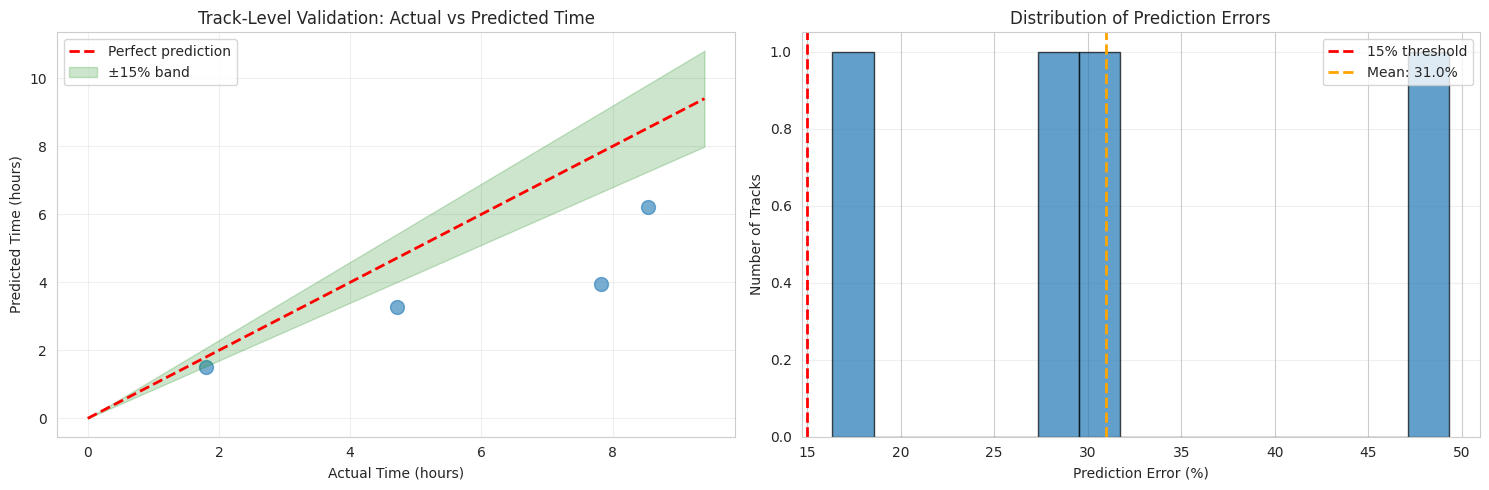

In [10]:
# Visualize validation results
if hiking_metrics is not None and len(validation_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Actual vs Predicted time
    axes[0].scatter(validation_results['actual_time_hours'], 
                    validation_results['predicted_time_hours'], 
                    s=100, alpha=0.6)
    
    # Add ±15% error bands
    x_range = np.linspace(0, validation_results['actual_time_hours'].max() * 1.1, 100)
    axes[0].plot(x_range, x_range, 'r--', lw=2, label='Perfect prediction')
    axes[0].fill_between(x_range, x_range * 0.85, x_range * 1.15, alpha=0.2, color='green', label='±15% band')
    
    axes[0].set_xlabel('Actual Time (hours)')
    axes[0].set_ylabel('Predicted Time (hours)')
    axes[0].set_title('Track-Level Validation: Actual vs Predicted Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    axes[1].hist(validation_results['time_error_pct'], bins=15, edgecolor='black', alpha=0.7)
    axes[1].axvline(15, color='red', linestyle='--', lw=2, label='15% threshold')
    axes[1].axvline(validation_results['time_error_pct'].mean(), color='orange', linestyle='--', lw=2, label=f'Mean: {validation_results["time_error_pct"].mean():.1f}%')
    axes[1].set_xlabel('Prediction Error (%)')
    axes[1].set_ylabel('Number of Tracks')
    axes[1].set_title('Distribution of Prediction Errors')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

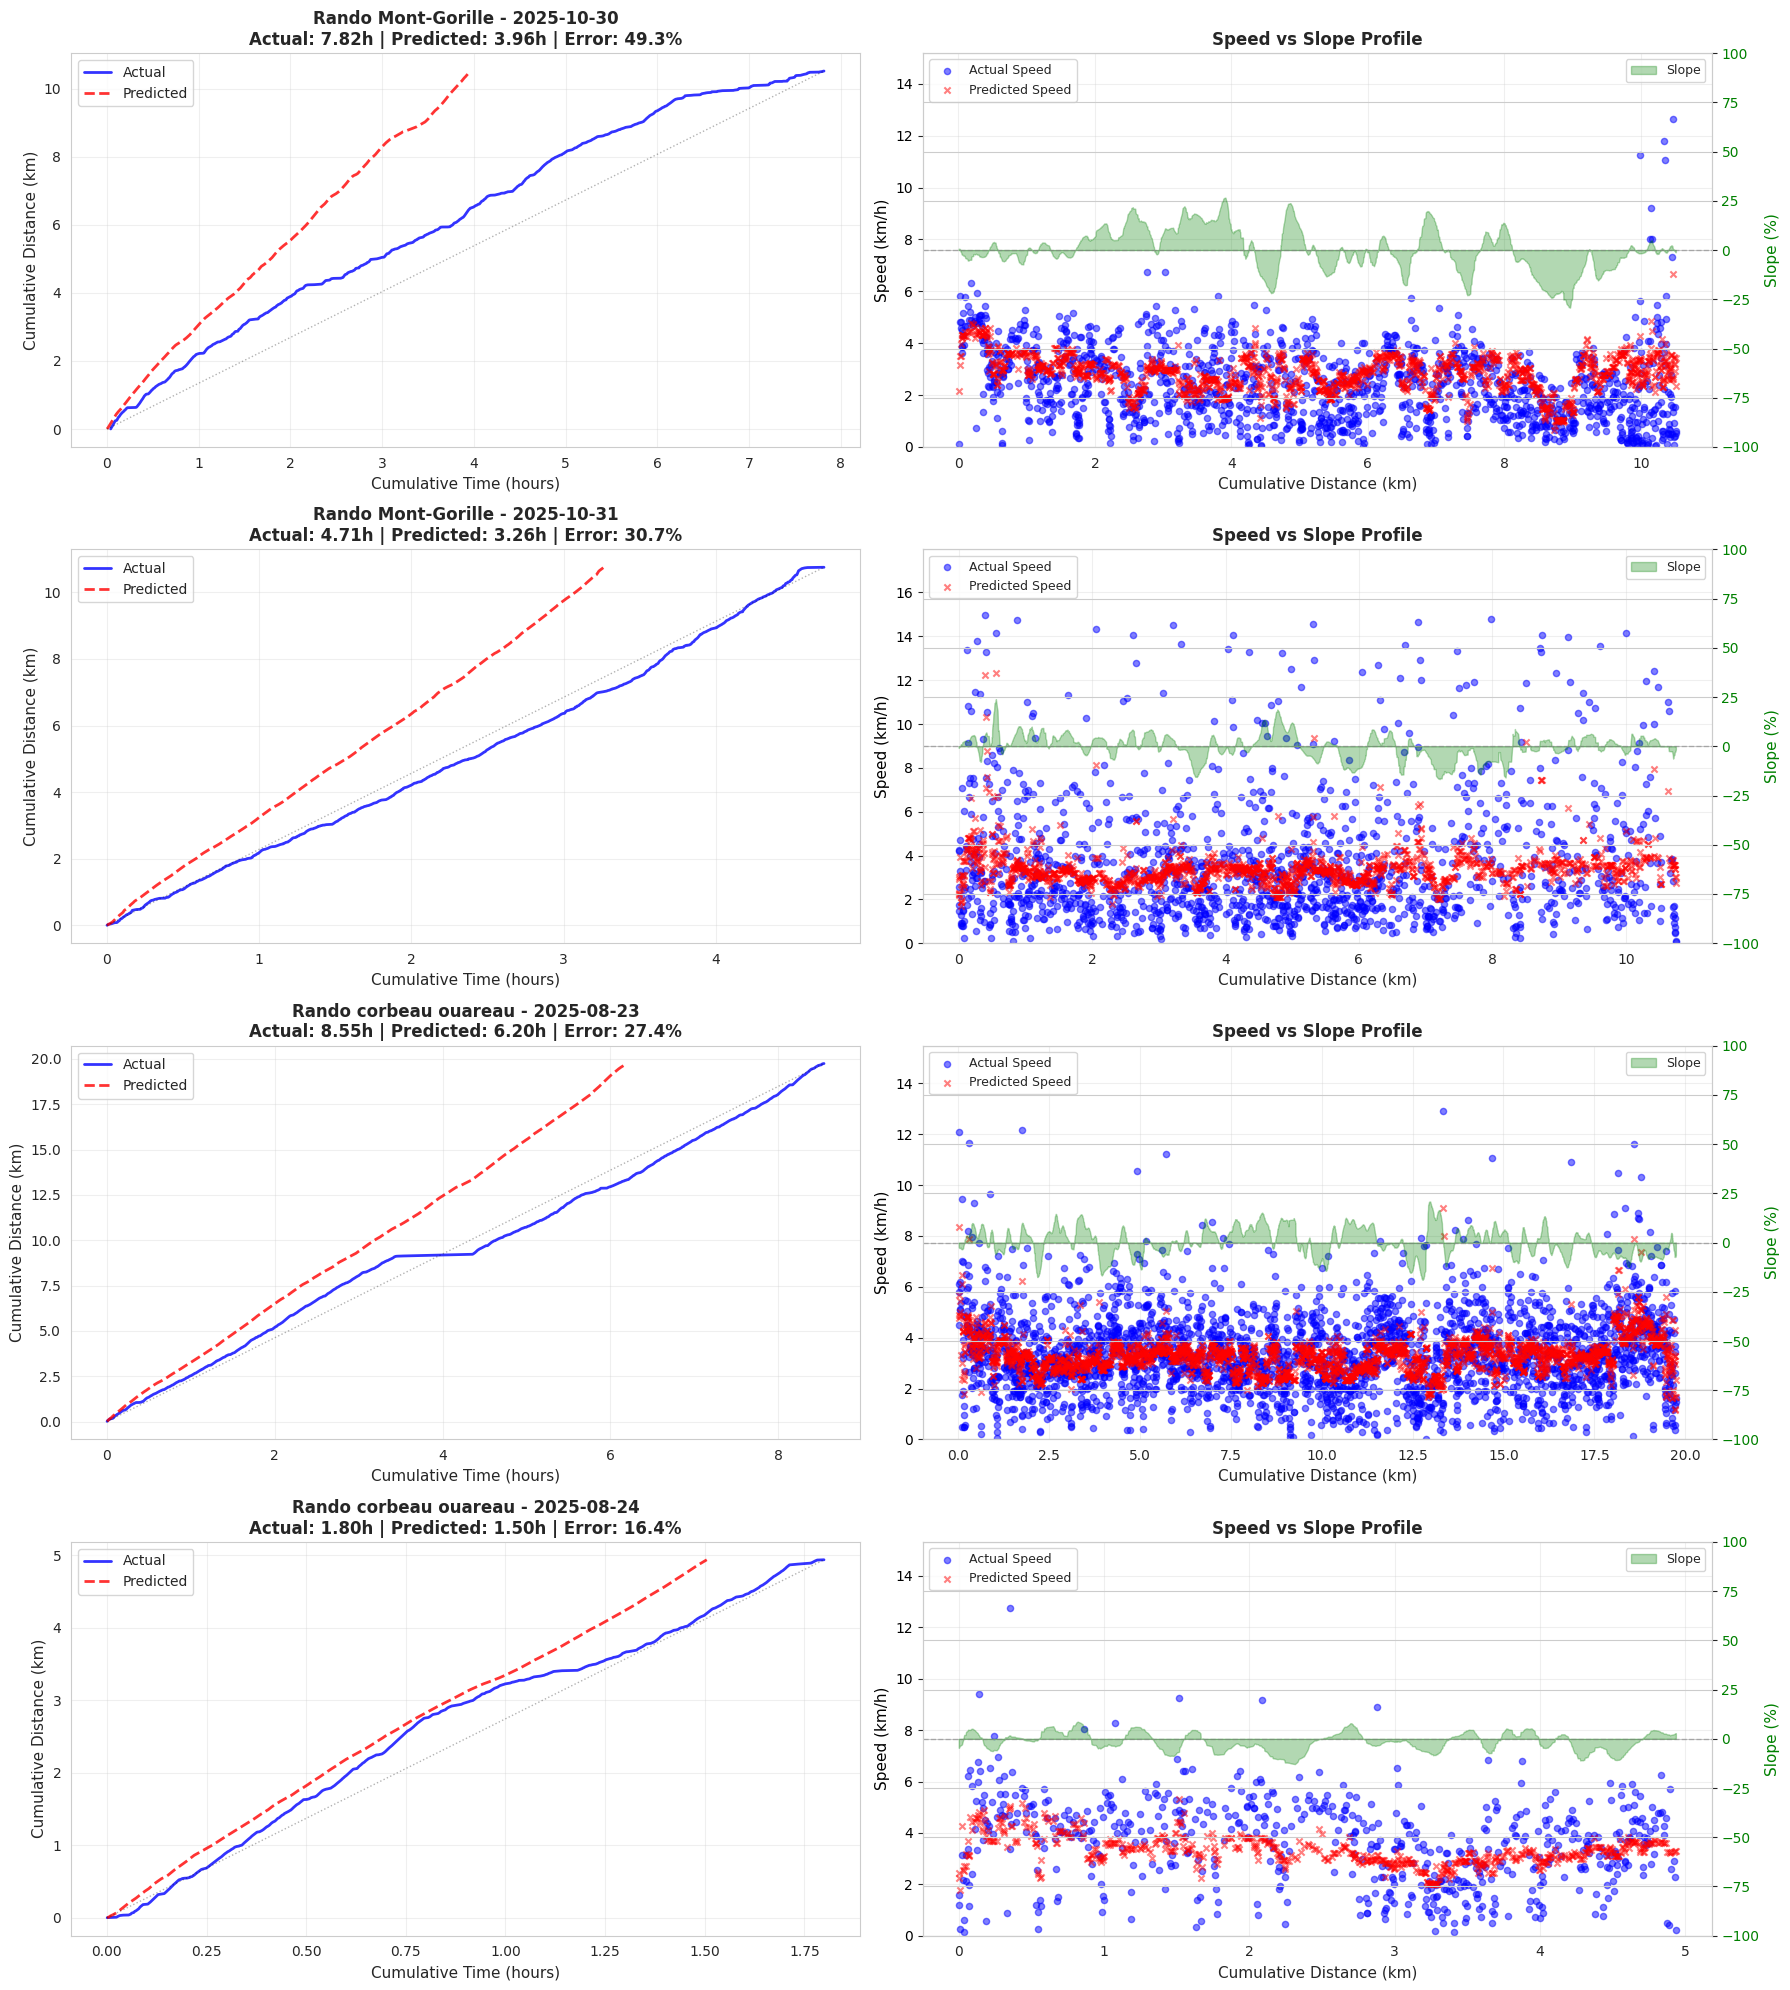


MODEL ERROR ANALYSIS BY TERRAIN TYPE

Speed Error by Terrain Type:
(Positive error = model overestimates speed)
              speed_error_pct               speed_kmh predicted_speed
                         mean     std count      mean            mean
terrain_type                                                         
Steep Descent           59.19  129.92    77      1.28            1.48
Descent                 47.61  193.74  1466      3.13            3.18
Flat                    83.79  442.00  3202      3.40            3.40
Ascent                  49.12  169.93  1594      2.98            2.97
Steep Ascent            41.30   92.25    54      2.14            2.24


Speed Error by Fatigue Level:
                 speed_error_pct               speed_kmh predicted_speed
                            mean     std count      mean            mean
fatigue_level                                                           
Fresh (0-1h)               60.25  259.24  1557      3.40            3.39
Mod

In [11]:
def plot_track_analysis(df, model, feature_cols):
    """
    Plot detailed track-by-track analysis showing predicted vs actual distance over time,
    with slope information to identify model weaknesses.
    """
    # Get unique track/date combinations
    track_dates = df.groupby(['track_name', 'date']).size().reset_index()[['track_name', 'date']]
    
    # Create subplots - one row per track
    n_tracks = len(track_dates)
    fig, axes = plt.subplots(n_tracks, 2, figsize=(18, 5*n_tracks))
    
    # Handle single track case
    if n_tracks == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, row) in enumerate(track_dates.iterrows()):
        track_name = row['track_name']
        date = row['date']
        
        # Get data for this track/date
        track_data = df[(df['track_name'] == track_name) & (df['date'] == date)].copy()
        
        if len(track_data) == 0:
            continue
        
        # Calculate cumulative distance (actual)
        track_data['cumulative_distance_km'] = track_data['distance_m'].cumsum() / 1000
        
        # Calculate predicted time for each segment
        X_pred = track_data[feature_cols]
        predicted_speeds = model.predict(X_pred)
        track_data['predicted_time_s'] = (track_data['distance_m'] / 1000) / predicted_speeds * 3600
        
        # Calculate cumulative times
        track_data['cumulative_actual_time_h'] = track_data['time_delta_s'].cumsum() / 3600
        track_data['cumulative_predicted_time_h'] = track_data['predicted_time_s'].cumsum() / 3600
        
        # LEFT PLOT: Distance over Time
        ax1 = axes[idx, 0]
        
        # Plot actual and predicted
        ax1.plot(track_data['cumulative_actual_time_h'], 
                track_data['cumulative_distance_km'], 
                'b-', linewidth=2, label='Actual', alpha=0.8)
        ax1.plot(track_data['cumulative_predicted_time_h'], 
                track_data['cumulative_distance_km'], 
                'r--', linewidth=2, label='Predicted', alpha=0.8)
        
        # Add diagonal reference line (perfect prediction would overlap)
        ax1.plot([0, track_data['cumulative_actual_time_h'].max()],
                [0, track_data['cumulative_distance_km'].max()],
                'k:', linewidth=1, alpha=0.3)
        
        ax1.set_xlabel('Cumulative Time (hours)', fontsize=11)
        ax1.set_ylabel('Cumulative Distance (km)', fontsize=11)
        ax1.set_title(f'{track_name} - {date}\n' + 
                     f'Actual: {track_data["cumulative_actual_time_h"].iloc[-1]:.2f}h | ' +
                     f'Predicted: {track_data["cumulative_predicted_time_h"].iloc[-1]:.2f}h | ' +
                     f'Error: {abs(track_data["cumulative_actual_time_h"].iloc[-1] - track_data["cumulative_predicted_time_h"].iloc[-1]) / track_data["cumulative_actual_time_h"].iloc[-1] * 100:.1f}%',
                     fontsize=12, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # RIGHT PLOT: Slope profile with speed comparison
        ax2 = axes[idx, 1]
        
        # Create twin axis for slope
        ax2_twin = ax2.twinx()
        
        # Plot speed (actual vs predicted) on left axis
        ax2.scatter(track_data['cumulative_distance_km'], 
                   track_data['speed_kmh'],
                   c='blue', alpha=0.5, s=20, label='Actual Speed')
        
        predicted_speed_segments = predicted_speeds
        ax2.scatter(track_data['cumulative_distance_km'], 
                   predicted_speed_segments,
                   c='red', alpha=0.5, s=20, marker='x', label='Predicted Speed')
        
        # Plot slope on right axis as filled area
        ax2_twin.fill_between(track_data['cumulative_distance_km'], 
                              0, track_data['slope_percent'],
                              alpha=0.3, color='green', label='Slope')
        ax2_twin.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        ax2.set_xlabel('Cumulative Distance (km)', fontsize=11)
        ax2.set_ylabel('Speed (km/h)', fontsize=11, color='black')
        ax2_twin.set_ylabel('Slope (%)', fontsize=11, color='green')
        ax2.set_title('Speed vs Slope Profile', fontsize=12, fontweight='bold')
        
        # Set y-axis limits for better visualization
        ax2.set_ylim(0, max(track_data['speed_kmh'].max(), predicted_speed_segments.max()) * 1.2)
        ax2_twin.set_ylim(-100, 100)
        
        ax2.legend(loc='upper left', fontsize=9)
        ax2_twin.legend(loc='upper right', fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='y', labelcolor='black')
        ax2_twin.tick_params(axis='y', labelcolor='green')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: where is the model wrong?
    print("\n" + "="*80)
    print("MODEL ERROR ANALYSIS BY TERRAIN TYPE")
    print("="*80)
    
    # Analyze prediction errors by slope category
    df['predicted_speed'] = model.predict(df[feature_cols])
    df['speed_error_pct'] = (df['predicted_speed'] - df['speed_kmh']) / df['speed_kmh'] * 100
    
    # Categorize by slope
    df['terrain_type'] = pd.cut(df['slope_percent'], 
                                 bins=[-np.inf, -20, -5, 5, 20, np.inf],
                                 labels=['Steep Descent', 'Descent', 'Flat', 'Ascent', 'Steep Ascent'])
    
    # Categorize by fatigue
    df['fatigue_level'] = pd.cut(df['cumulative_hours'],
                                  bins=[0, 1, 2, 3, np.inf],
                                  labels=['Fresh (0-1h)', 'Moderate (1-2h)', 'Tired (2-3h)', 'Very Tired (>3h)'])
    
    print("\nSpeed Error by Terrain Type:")
    print("(Positive error = model overestimates speed)")
    terrain_analysis = df.groupby('terrain_type').agg({
        'speed_error_pct': ['mean', 'std', 'count'],
        'speed_kmh': 'mean',
        'predicted_speed': 'mean'
    }).round(2)
    print(terrain_analysis)
    
    print("\n\nSpeed Error by Fatigue Level:")
    fatigue_analysis = df.groupby('fatigue_level').agg({
        'speed_error_pct': ['mean', 'std', 'count'],
        'speed_kmh': 'mean',
        'predicted_speed': 'mean'
    }).round(2)
    print(fatigue_analysis)
    
    print("\n\nSpeed Error by Terrain × Fatigue:")
    combined_analysis = df.groupby(['terrain_type', 'fatigue_level'])['speed_error_pct'].mean().round(2)
    print(combined_analysis)
    
    return df


# Run the detailed analysis
if hiking_metrics is not None:
    analyzed_df = plot_track_analysis(model_data, model, feature_cols)

## Usage Guide for Visualization Cells

### Cell 17: Error Pattern Visualization (Heatmaps)
**Run this after**: Cell 16 (Track Analysis with `plot_track_analysis`)

**What it shows**:
- 4 visualizations analyzing prediction errors by terrain type × fatigue level
- Heatmap showing where the model fails most
- Sample count heatmap (data availability)
- Actual vs Predicted scatter plot
- Top 10 worst error combinations

**Key insights**: Identifies specific terrain/fatigue combinations with high errors (e.g., flat terrain when very tired)

---

### Cell 22: Speed & Slope Comparison Plots
**Run this after**: Cell 21 (Route-Based Validation)

**What it shows**:
- Detailed line plots for each validated route
- Speed over distance (predicted vs actual)
- Slope over distance (predicted vs actual)
- Both raw and smoothed data with statistics

**Key insights**: Shows exactly where along each route the predictions diverge from reality

---

### Execution Order

1. Run cells 1-16 (data loading, model training, track analysis)
2. **Run cell 17** to see error heatmaps
3. Run cells 18-21 (route validation)
4. **Run cell 22** to see detailed route comparisons


Creating error pattern visualizations...


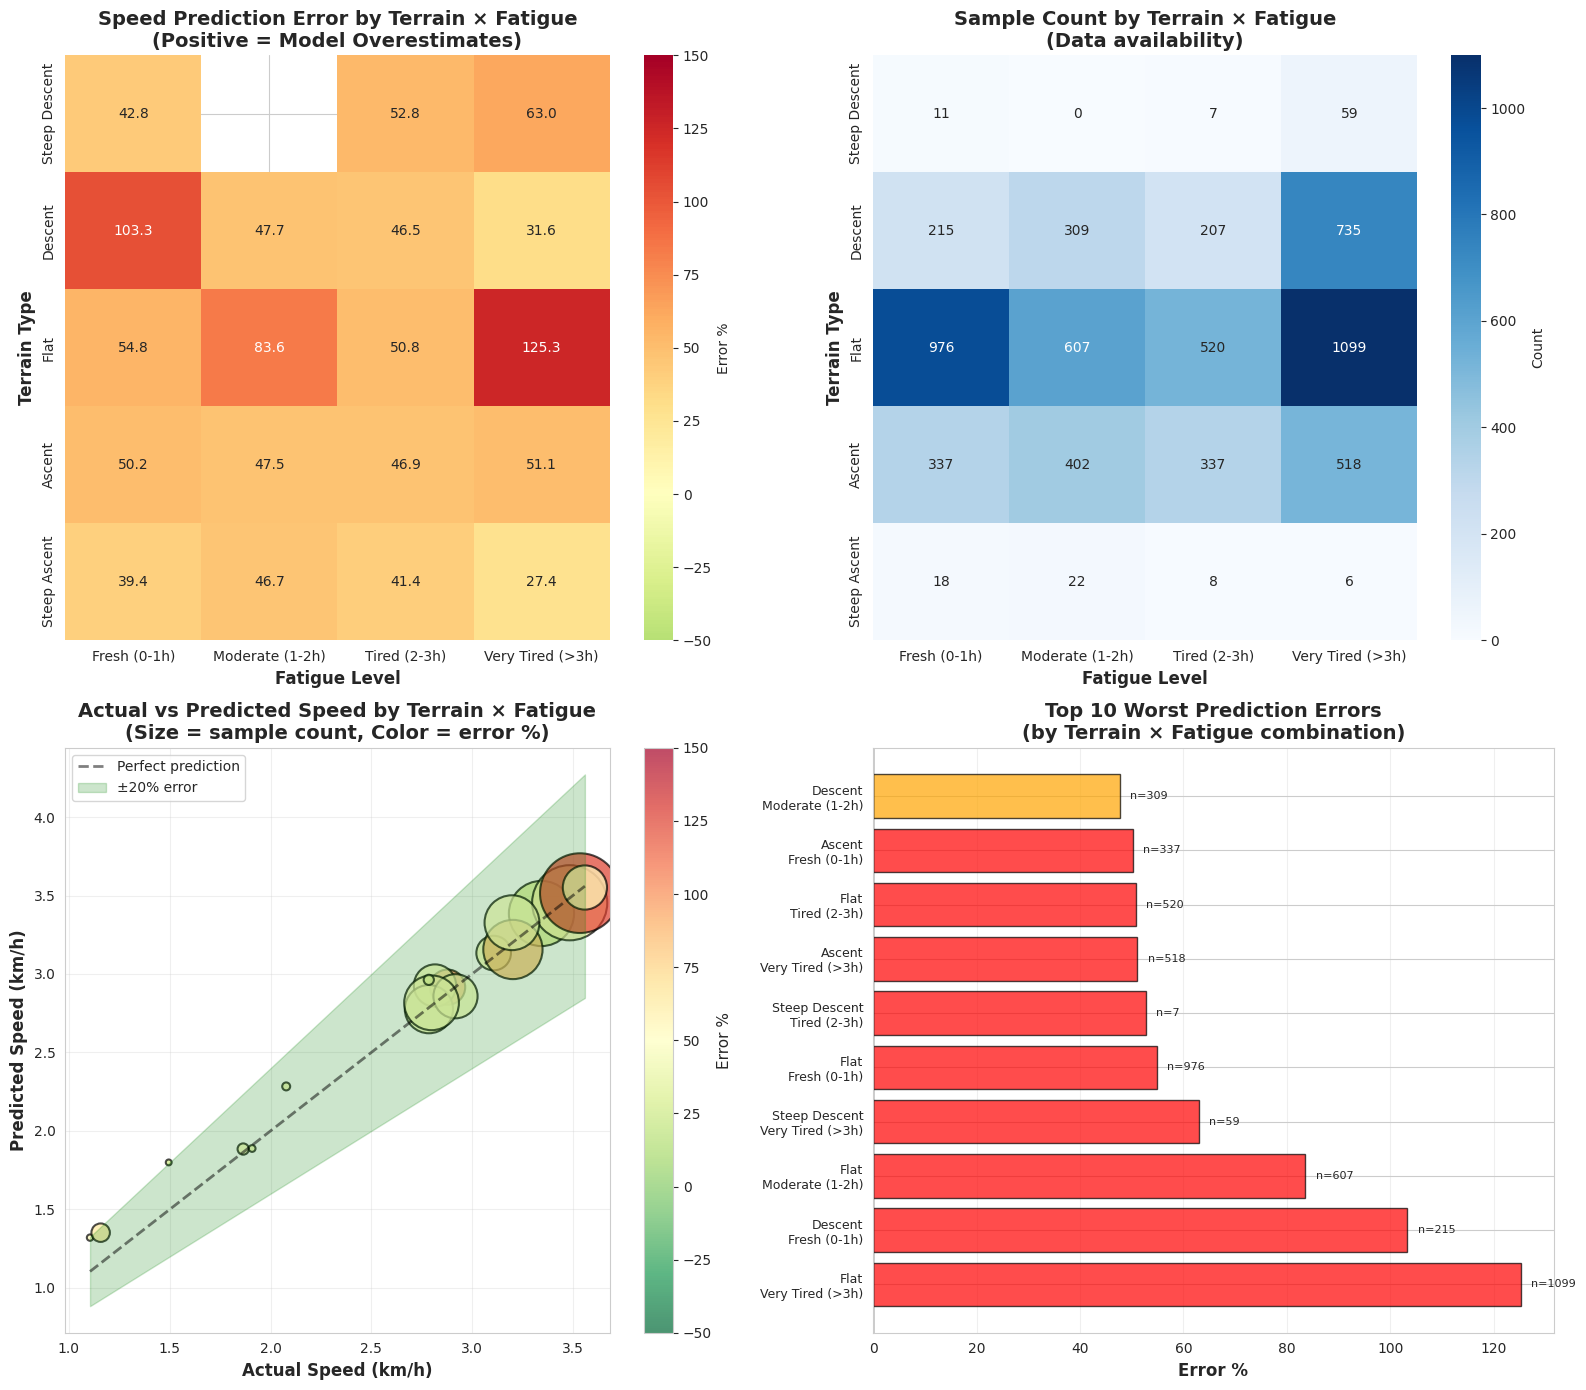


KEY INSIGHTS FROM ERROR ANALYSIS

WORST prediction: Flat
Very Tired (>3h)
  Error: 125.3%
  Actual: 3.53 km/h
  Predicted: 3.52 km/h
  Samples: 1099

RECOMMENDATIONS:

⚠ CRITICAL: Some combinations have >100% error!
  → Model has severe issues with certain terrain/fatigue combinations


In [12]:
# ============================================================
# VISUALIZE ERROR PATTERNS: Terrain × Fatigue Heatmap
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

if 'analyzed_df' in dir() and analyzed_df is not None:
    print("Creating error pattern visualizations...")
    
    # Prepare data for heatmap
    pivot_error = analyzed_df.groupby(['terrain_type', 'fatigue_level'])['speed_error_pct'].mean().unstack()
    pivot_count = analyzed_df.groupby(['terrain_type', 'fatigue_level']).size().unstack()
    pivot_actual = analyzed_df.groupby(['terrain_type', 'fatigue_level'])['speed_kmh'].mean().unstack()
    pivot_predicted = analyzed_df.groupby(['terrain_type', 'fatigue_level'])['predicted_speed'].mean().unstack()
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # 1. Error % Heatmap
    ax1 = axes[0, 0]
    sns.heatmap(pivot_error, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                center=0, vmin=-50, vmax=150, ax=ax1, cbar_kws={'label': 'Error %'})
    ax1.set_title('Speed Prediction Error by Terrain × Fatigue\n(Positive = Model Overestimates)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fatigue Level', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Terrain Type', fontsize=12, fontweight='bold')
    
    # 2. Sample Count Heatmap
    ax2 = axes[0, 1]
    sns.heatmap(pivot_count, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar_kws={'label': 'Count'})
    ax2.set_title('Sample Count by Terrain × Fatigue\n(Data availability)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Fatigue Level', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Terrain Type', fontsize=12, fontweight='bold')
    
    # 3. Actual vs Predicted Speed
    ax3 = axes[1, 0]
    
    # Flatten the data for scatter plot
    terrain_fatigue_pairs = []
    actual_speeds = []
    predicted_speeds = []
    errors = []
    counts = []
    
    for terrain in pivot_error.index:
        for fatigue in pivot_error.columns:
            if not pd.isna(pivot_error.loc[terrain, fatigue]):
                terrain_fatigue_pairs.append(f"{terrain}\n{fatigue}")
                actual_speeds.append(pivot_actual.loc[terrain, fatigue])
                predicted_speeds.append(pivot_predicted.loc[terrain, fatigue])
                errors.append(pivot_error.loc[terrain, fatigue])
                counts.append(pivot_count.loc[terrain, fatigue])
    
    # Create scatter plot with color based on error
    scatter = ax3.scatter(actual_speeds, predicted_speeds, 
                         c=errors, cmap='RdYlGn_r', s=[c*3 for c in counts],
                         alpha=0.7, edgecolors='black', linewidth=1.5,
                         vmin=-50, vmax=150)
    
    # Add diagonal line (perfect prediction)
    max_speed = max(max(actual_speeds), max(predicted_speeds))
    min_speed = min(min(actual_speeds), min(predicted_speeds))
    ax3.plot([min_speed, max_speed], [min_speed, max_speed], 
             'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    # Add ±20% error bands
    x_range = np.linspace(min_speed, max_speed, 100)
    ax3.fill_between(x_range, x_range * 0.8, x_range * 1.2, 
                     alpha=0.2, color='green', label='±20% error')
    
    ax3.set_xlabel('Actual Speed (km/h)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Predicted Speed (km/h)', fontsize=12, fontweight='bold')
    ax3.set_title('Actual vs Predicted Speed by Terrain × Fatigue\n(Size = sample count, Color = error %)',
                 fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Error %', fontsize=11)
    
    # 4. Error distribution by category
    ax4 = axes[1, 1]
    
    # Sort terrain-fatigue pairs by error
    sorted_indices = np.argsort(errors)[::-1]
    sorted_pairs = [terrain_fatigue_pairs[i] for i in sorted_indices]
    sorted_errors = [errors[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]
    
    # Show top 10 worst errors
    top_n = min(10, len(sorted_pairs))
    colors = ['red' if e > 50 else 'orange' if e > 30 else 'yellow' for e in sorted_errors[:top_n]]
    
    bars = ax4.barh(range(top_n), sorted_errors[:top_n], color=colors, alpha=0.7, edgecolor='black')
    ax4.set_yticks(range(top_n))
    ax4.set_yticklabels(sorted_pairs[:top_n], fontsize=9)
    ax4.set_xlabel('Error %', fontsize=12, fontweight='bold')
    ax4.set_title('Top 10 Worst Prediction Errors\n(by Terrain × Fatigue combination)',
                 fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    ax4.axvline(x=0, color='black', linewidth=1)
    
    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars, sorted_counts[:top_n])):
        ax4.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
                f'n={count}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print key insights
    print("\n" + "="*60)
    print("KEY INSIGHTS FROM ERROR ANALYSIS")
    print("="*60)
    
    # Find worst combinations
    worst_idx = np.argmax(errors)
    print(f"\nWORST prediction: {terrain_fatigue_pairs[worst_idx]}")
    print(f"  Error: {errors[worst_idx]:.1f}%")
    print(f"  Actual: {actual_speeds[worst_idx]:.2f} km/h")
    print(f"  Predicted: {predicted_speeds[worst_idx]:.2f} km/h")
    print(f"  Samples: {counts[worst_idx]}")
    
    print(f"\n{'='*60}")
    print("RECOMMENDATIONS:")
    print("="*60)
    
    if any(e > 100 for e in errors):
        print("\n⚠ CRITICAL: Some combinations have >100% error!")
        print("  → Model has severe issues with certain terrain/fatigue combinations")
    
else:
    print("⚠ No analyzed data found. Run the previous analysis cell first.")


INVESTIGATING: Very Tired + Flat Terrain Segments

Found 1099 segments matching 'Flat + Very Tired'

------------------------------------------------------------
DISTRIBUTION BY TRACK AND DATE:
------------------------------------------------------------
                                 speed_kmh             predicted_speed  \
                                     count  mean   std            mean   
track_name            date                                               
Rando Mont-Gorille    2025-10-30       166  2.07  2.31            3.18   
                      2025-10-31       274  4.38  3.36            3.74   
Rando corbeau ouareau 2025-08-23       659  3.55  1.59            3.51   

                                 speed_error_pct cumulative_hours        \
                                            mean              min   max   
track_name            date                                                
Rando Mont-Gorille    2025-10-30          523.25             3.61  5.52   


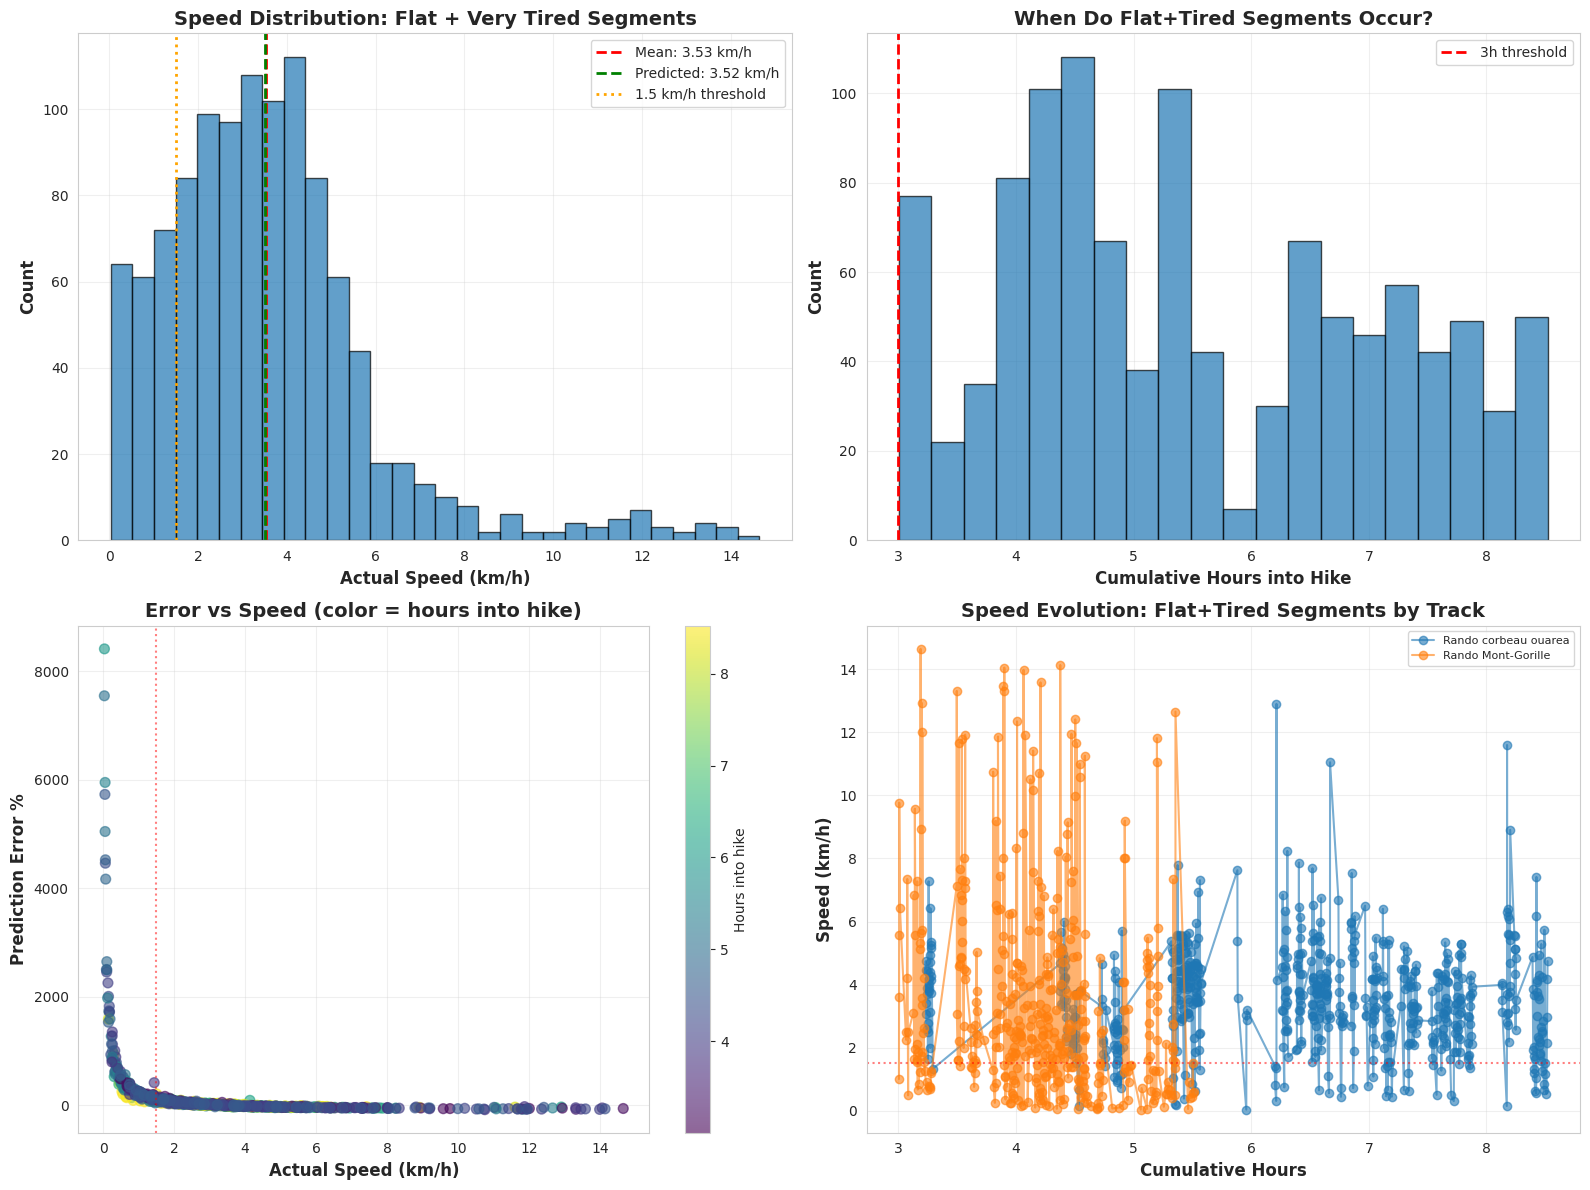


DIAGNOSIS:

✓ Data looks reasonable
   Average speed: 3.53 km/h
   This represents genuine fatigue effect on flat terrain


In [13]:
# ============================================================
# DIAGNOSTIC: Very Tired + Flat Terrain Analysis
# ============================================================
# Investigate where "very tired on flat" segments occur
# to check if the 125% error is a data artifact

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if 'analyzed_df' in dir() and analyzed_df is not None:
    print("="*60)
    print("INVESTIGATING: Very Tired + Flat Terrain Segments")
    print("="*60)
    
    # Filter to the problematic combination
    flat_tired = analyzed_df[
        (analyzed_df['terrain_type'] == 'Flat') & 
        (analyzed_df['fatigue_level'] == 'Very Tired (>3h)')
    ].copy()
    
    print(f"\nFound {len(flat_tired)} segments matching 'Flat + Very Tired'")
    
    if len(flat_tired) > 0:
        # Group by track and date to see when these occur
        print("\n" + "-"*60)
        print("DISTRIBUTION BY TRACK AND DATE:")
        print("-"*60)
        
        track_distribution = flat_tired.groupby(['track_name', 'date']).agg({
            'speed_kmh': ['count', 'mean', 'std'],
            'predicted_speed': 'mean',
            'speed_error_pct': 'mean',
            'cumulative_hours': ['min', 'max'],
            'slope_percent': ['mean', 'std']
        }).round(2)
        
        print(track_distribution)
        
        # Analyze timing within each hike
        print("\n" + "-"*60)
        print("WHEN DO THESE SEGMENTS OCCUR IN EACH HIKE:")
        print("-"*60)
        
        for track_name in flat_tired['track_name'].unique():
            track_segments = flat_tired[flat_tired['track_name'] == track_name]
            
            print(f"\n{track_name}:")
            for date in track_segments['date'].unique():
                day_segments = track_segments[track_segments['date'] == date]
                
                print(f"  Date: {date}")
                print(f"    Count: {len(day_segments)} segments")
                print(f"    Time range: {day_segments['cumulative_hours'].min():.2f}h - {day_segments['cumulative_hours'].max():.2f}h")
                print(f"    Actual speed: {day_segments['speed_kmh'].mean():.2f} ± {day_segments['speed_kmh'].std():.2f} km/h")
                print(f"    Predicted speed: {day_segments['predicted_speed'].mean():.2f} km/h")
                print(f"    Error: {day_segments['speed_error_pct'].mean():.1f}%")
                print(f"    Slope: {day_segments['slope_percent'].mean():.2f} ± {day_segments['slope_percent'].std():.2f}%")
                
                # Check if these are at the end of hike (potential end-of-day slowdown)
                total_hike_hours = hiking_metrics[
                    (hiking_metrics['track_name'] == track_name) & 
                    (hiking_metrics['date'] == date)
                ]['cumulative_hours'].max()
                
                pct_into_hike = (day_segments['cumulative_hours'].mean() / total_hike_hours) * 100
                print(f"    Position: {pct_into_hike:.0f}% into hike")
                
                if pct_into_hike > 80:
                    print(f"    ⚠️  WARNING: These occur near END of hike - could be rest/breaks!")
        
        # Check speed distribution
        print("\n" + "-"*60)
        print("SPEED DISTRIBUTION ANALYSIS:")
        print("-"*60)
        
        print(f"\nActual speeds (Flat + Very Tired):")
        print(f"  Min: {flat_tired['speed_kmh'].min():.2f} km/h")
        print(f"  25th percentile: {flat_tired['speed_kmh'].quantile(0.25):.2f} km/h")
        print(f"  Median: {flat_tired['speed_kmh'].median():.2f} km/h")
        print(f"  75th percentile: {flat_tired['speed_kmh'].quantile(0.75):.2f} km/h")
        print(f"  Max: {flat_tired['speed_kmh'].max():.2f} km/h")
        print(f"  Mean: {flat_tired['speed_kmh'].mean():.2f} km/h")
        
        # Count very slow segments (potential breaks)
        very_slow = flat_tired[flat_tired['speed_kmh'] < 1.5]
        slow = flat_tired[(flat_tired['speed_kmh'] >= 1.5) & (flat_tired['speed_kmh'] < 2.5)]
        normal = flat_tired[flat_tired['speed_kmh'] >= 2.5]
        
        print(f"\n  Very slow (<1.5 km/h): {len(very_slow)} segments ({len(very_slow)/len(flat_tired)*100:.1f}%)")
        print(f"  Slow (1.5-2.5 km/h): {len(slow)} segments ({len(slow)/len(flat_tired)*100:.1f}%)")
        print(f"  Normal (>2.5 km/h): {len(normal)} segments ({len(normal)/len(flat_tired)*100:.1f}%)")
        
        if len(very_slow) > 0:
            print(f"\n  ⚠️  {len(very_slow)/len(flat_tired)*100:.1f}% of segments are VERY SLOW (<1.5 km/h)")
            print(f"      These might be unfiltered breaks/rests!")
        
        # Check time deltas (gaps between consecutive points)
        print("\n" + "-"*60)
        print("TIME GAP ANALYSIS (checking for unfiltered breaks):")
        print("-"*60)
        
        # Calculate time gaps for these segments
        time_gaps = []
        for track_name in flat_tired['track_name'].unique():
            for date in flat_tired[flat_tired['track_name'] == track_name]['date'].unique():
                # Get all segments for this track/date
                all_day_segments = hiking_metrics[
                    (hiking_metrics['track_name'] == track_name) & 
                    (hiking_metrics['date'] == date)
                ].sort_values('time')
                
                # Find which ones are in our flat_tired set
                flat_tired_day = flat_tired[
                    (flat_tired['track_name'] == track_name) & 
                    (flat_tired['date'] == date)
                ]
                
                if len(flat_tired_day) > 0:
                    # For each flat_tired segment, check the time delta
                    for idx in flat_tired_day.index:
                        if idx in all_day_segments.index:
                            pos = all_day_segments.index.get_loc(idx)
                            if pos > 0:
                                prev_idx = all_day_segments.index[pos - 1]
                                time_gap = (all_day_segments.loc[idx, 'time'] - 
                                          all_day_segments.loc[prev_idx, 'time']).total_seconds() / 60
                                time_gaps.append(time_gap)
        
        if len(time_gaps) > 0:
            time_gaps = np.array(time_gaps)
            print(f"\nTime gaps before flat+tired segments:")
            print(f"  Median: {np.median(time_gaps):.1f} minutes")
            print(f"  Mean: {np.mean(time_gaps):.1f} minutes")
            print(f"  Max: {np.max(time_gaps):.1f} minutes")
            print(f"  >10 min: {(time_gaps > 10).sum()} segments ({(time_gaps > 10).sum()/len(time_gaps)*100:.1f}%)")
            print(f"  >20 min: {(time_gaps > 20).sum()} segments ({(time_gaps > 20).sum()/len(time_gaps)*100:.1f}%)")
            print(f"  >30 min: {(time_gaps > 30).sum()} segments ({(time_gaps > 30).sum()/len(time_gaps)*100:.1f}%)")
            
            if (time_gaps > 20).sum() > 0:
                print(f"\n  ⚠️  WARNING: {(time_gaps > 20).sum()} segments have >20min gap before them")
                print(f"      These are likely POST-BREAK segments (very slow speed resuming)")
        
        # Visualize the segments
        print("\n" + "-"*60)
        print("CREATING VISUALIZATION...")
        print("-"*60)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Speed histogram
        ax1 = axes[0, 0]
        ax1.hist(flat_tired['speed_kmh'], bins=30, edgecolor='black', alpha=0.7)
        ax1.axvline(flat_tired['speed_kmh'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {flat_tired["speed_kmh"].mean():.2f} km/h')
        ax1.axvline(flat_tired['predicted_speed'].mean(), color='green', linestyle='--',
                   linewidth=2, label=f'Predicted: {flat_tired["predicted_speed"].mean():.2f} km/h')
        ax1.axvline(1.5, color='orange', linestyle=':', linewidth=2, label='1.5 km/h threshold')
        ax1.set_xlabel('Actual Speed (km/h)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax1.set_title('Speed Distribution: Flat + Very Tired Segments', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Cumulative hours when these occur
        ax2 = axes[0, 1]
        ax2.hist(flat_tired['cumulative_hours'], bins=20, edgecolor='black', alpha=0.7)
        ax2.axvline(3, color='red', linestyle='--', linewidth=2, label='3h threshold')
        ax2.set_xlabel('Cumulative Hours into Hike', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax2.set_title('When Do Flat+Tired Segments Occur?', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Error vs speed
        ax3 = axes[1, 0]
        scatter = ax3.scatter(flat_tired['speed_kmh'], flat_tired['speed_error_pct'],
                            c=flat_tired['cumulative_hours'], cmap='viridis',
                            alpha=0.6, s=50)
        ax3.set_xlabel('Actual Speed (km/h)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Prediction Error %', fontsize=12, fontweight='bold')
        ax3.set_title('Error vs Speed (color = hours into hike)', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.axvline(1.5, color='red', linestyle=':', alpha=0.5)
        plt.colorbar(scatter, ax=ax3, label='Hours into hike')
        
        # 4. Speed over time across all flat+tired segments
        ax4 = axes[1, 1]
        for track_name in flat_tired['track_name'].unique():
            track_data = flat_tired[flat_tired['track_name'] == track_name].sort_values('cumulative_hours')
            ax4.plot(track_data['cumulative_hours'], track_data['speed_kmh'], 
                    'o-', alpha=0.6, label=track_name[:20])
        ax4.set_xlabel('Cumulative Hours', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Speed (km/h)', fontsize=12, fontweight='bold')
        ax4.set_title('Speed Evolution: Flat+Tired Segments by Track', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=8)
        ax4.grid(True, alpha=0.3)
        ax4.axhline(1.5, color='red', linestyle=':', alpha=0.5, label='Slow threshold')
        
        plt.tight_layout()
        plt.show()
        
        # Final diagnosis
        print("\n" + "="*60)
        print("DIAGNOSIS:")
        print("="*60)
        
        avg_speed = flat_tired['speed_kmh'].mean()
        pct_very_slow = (flat_tired['speed_kmh'] < 1.5).sum() / len(flat_tired) * 100
        avg_time_gap = np.mean(time_gaps) if len(time_gaps) > 0 else 0
        
        if pct_very_slow > 30:
            print("\n⚠️  LIKELY DATA ARTIFACT!")
            print(f"   {pct_very_slow:.1f}% of segments are <1.5 km/h (very slow)")
            print("   These are probably UNFILTERED BREAKS or POST-BREAK segments")
            print("\n   RECOMMENDATION:")
            print("   1. Filter out segments with speed <1.5 km/h from training data")
            print("   2. Or increase break filtering threshold from 60min to 30min")
        elif avg_speed < 2.5:
            print("\n⚠️  PARTIALLY DATA ARTIFACT")
            print(f"   Average speed is only {avg_speed:.2f} km/h")
            print("   This is slower than normal hiking - likely includes pauses")
            print("\n   RECOMMENDATION:")
            print("   Filter segments with speed <2.0 km/h from training data")
        else:
            print("\n✓ Data looks reasonable")
            print(f"   Average speed: {avg_speed:.2f} km/h")
            print("   This represents genuine fatigue effect on flat terrain")
    
else:
    print("⚠ No analyzed data found. Run the track analysis cell first.")


In [ ]:
# ============================================================
# ALTITUDE PROFILES: Route Analysis
# ============================================================
# Plot altitude profiles to verify terrain classification

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def plot_altitude_profile_with_terrain(route_name, show_terrain_classification=True):
    """
    Plot altitude profile for a route and optionally show terrain classification.
    """
    print(f"\nAnalyzing: {route_name}")
    print("-" * 60)
    
    # Load route data
    routes_df = pd.read_csv(routes_folder / 'routes.csv')
    route_file = routes_df[routes_df['route_name'] == route_name]['file_name'].iloc[0]
    route_path = routes_folder / route_file
    
    # Get route with elevation
    route_df = load_gpx_route(route_path)
    route_metrics = calculate_route_metrics(route_df, slope_window_distance_m=100, interpolate=True)
    
    # Calculate cumulative distance
    route_metrics['cumulative_distance_km'] = route_metrics['distance_m'].cumsum() / 1000
    
    # Classify terrain (same as in analysis)
    def classify_terrain(slope):
        if slope > 15:
            return 'Steep Ascent'
        elif slope > 5:
            return 'Ascent'
        elif slope > -5:
            return 'Flat'
        elif slope > -15:
            return 'Descent'
        else:
            return 'Steep Descent'
    
    route_metrics['terrain_type'] = route_metrics['slope_percent'].apply(classify_terrain)
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # 1. Altitude profile
    ax1 = axes[0]
    ax1.fill_between(route_metrics['cumulative_distance_km'], 
                     route_metrics['elevation_m'], 
                     alpha=0.3, color='brown')
    ax1.plot(route_metrics['cumulative_distance_km'], 
            route_metrics['elevation_m'], 
            'b-', linewidth=2)
    
    ax1.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{route_name} - Altitude Profile', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add elevation stats
    elev_gain = route_metrics[route_metrics['elevation_change_m'] > 0]['elevation_change_m'].sum()
    elev_loss = abs(route_metrics[route_metrics['elevation_change_m'] < 0]['elevation_change_m'].sum())
    total_distance = route_metrics['distance_m'].sum() / 1000
    
    stats_text = f'Distance: {total_distance:.2f} km\n'
    stats_text += f'Elev Gain: {elev_gain:.0f} m\n'
    stats_text += f'Elev Loss: {elev_loss:.0f} m\n'
    stats_text += f'Min: {route_metrics["elevation_m"].min():.0f} m\n'
    stats_text += f'Max: {route_metrics["elevation_m"].max():.0f} m'
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2. Slope profile
    ax2 = axes[1]
    
    # Color by slope
    colors = []
    for slope in route_metrics['slope_percent']:
        if slope > 15:
            colors.append('darkred')
        elif slope > 5:
            colors.append('red')
        elif slope > -5:
            colors.append('green')
        elif slope > -15:
            colors.append('blue')
        else:
            colors.append('darkblue')
    
    # Plot slope as bars
    ax2.bar(route_metrics['cumulative_distance_km'], 
           route_metrics['slope_percent'],
           width=route_metrics['cumulative_distance_km'].diff().fillna(0.01),
           color=colors, alpha=0.7, edgecolor='none')
    
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=5, color='red', linestyle='--', linewidth=0.5, alpha=0.5, label='Ascent threshold (5%)')
    ax2.axhline(y=-5, color='blue', linestyle='--', linewidth=0.5, alpha=0.5, label='Descent threshold (-5%)')
    ax2.axhline(y=15, color='darkred', linestyle=':', linewidth=0.5, alpha=0.5, label='Steep threshold (15%)')
    ax2.axhline(y=-15, color='darkblue', linestyle=':', linewidth=0.5, alpha=0.5)
    
    ax2.set_ylabel('Slope (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'{route_name} - Slope Profile', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # 3. Terrain classification over distance
    ax3 = axes[2]
    
    # Create color-coded segments
    terrain_colors = {
        'Steep Ascent': 'darkred',
        'Ascent': 'red',
        'Flat': 'green',
        'Descent': 'blue',
        'Steep Descent': 'darkblue'
    }
    
    for i in range(len(route_metrics) - 1):
        terrain = route_metrics.iloc[i]['terrain_type']
        x_start = route_metrics.iloc[i]['cumulative_distance_km']
        x_end = route_metrics.iloc[i + 1]['cumulative_distance_km']
        ax3.axvspan(x_start, x_end, facecolor=terrain_colors[terrain], alpha=0.7)
    
    ax3.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Terrain Type', fontsize=12, fontweight='bold')
    ax3.set_title(f'{route_name} - Terrain Classification', fontsize=14, fontweight='bold')
    ax3.set_ylim([0, 1])
    ax3.set_yticks([])
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=terrain, alpha=0.7) 
                      for terrain, color in terrain_colors.items()]
    ax3.legend(handles=legend_elements, loc='upper left', ncol=5, fontsize=9)
    
    # Align x-axes
    for ax in axes:
        ax.set_xlim([0, route_metrics['cumulative_distance_km'].max()])
    
    plt.tight_layout()
    plt.show()
    
    # Print terrain distribution
    print(f"\nTerrain Distribution:")
    terrain_dist = route_metrics.groupby('terrain_type').agg({
        'distance_m': 'sum',
        'slope_percent': ['mean', 'min', 'max']
    }).round(2)
    terrain_dist['distance_km'] = terrain_dist['distance_m']['sum'] / 1000
    terrain_dist['percentage'] = (terrain_dist['distance_m']['sum'] / route_metrics['distance_m'].sum()) * 100
    
    for terrain in terrain_dist.index:
        dist_km = terrain_dist.loc[terrain, 'distance_km']
        pct = terrain_dist.loc[terrain, 'percentage']
        slope_mean = terrain_dist.loc[terrain, ('slope_percent', 'mean')]
        slope_min = terrain_dist.loc[terrain, ('slope_percent', 'min')]
        slope_max = terrain_dist.loc[terrain, ('slope_percent', 'max')]
        
        print(f"  {terrain:15s}: {dist_km:5.2f} km ({pct:5.1f}%) | "
              f"Slope: {slope_mean:+5.1f}% (range: {slope_min:+5.1f}% to {slope_max:+5.1f}%)")
    
    return route_metrics


def plot_track_altitude_profile(track_name, date=None):
    """
    Plot altitude profile for actual GPS track data.
    """
    print(f"\nAnalyzing Track: {track_name}")
    if date:
        print(f"Date: {date}")
    print("-" * 60)
    
    # Get track data
    track_data = hiking_metrics[hiking_metrics['track_name'].str.contains(
        track_name.split()[1] if len(track_name.split()) > 1 else track_name,
        case=False, na=False
    )].copy()
    
    if date:
        track_data = track_data[track_data['date'] == date]
    
    if len(track_data) == 0:
        print(f"No data found for {track_name}")
        return
    
    # Sort by time
    track_data = track_data.sort_values('time').reset_index(drop=True)
    track_data['cumulative_distance_km'] = track_data['distance_m'].cumsum() / 1000
    
    # Classify terrain
    def classify_terrain(slope):
        if slope > 15:
            return 'Steep Ascent'
        elif slope > 5:
            return 'Ascent'
        elif slope > -5:
            return 'Flat'
        elif slope > -15:
            return 'Descent'
        else:
            return 'Steep Descent'
    
    track_data['terrain_type'] = track_data['slope_percent'].apply(classify_terrain)
    
    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # 1. Altitude profile
    ax1 = axes[0]
    ax1.fill_between(track_data['cumulative_distance_km'], 
                     track_data['elevation_m'], 
                     alpha=0.3, color='brown')
    ax1.plot(track_data['cumulative_distance_km'], 
            track_data['elevation_m'], 
            'b-', linewidth=2)
    
    ax1.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{track_name} - Actual Track Altitude Profile', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Slope profile
    ax2 = axes[1]
    ax2.plot(track_data['cumulative_distance_km'], 
            track_data['slope_percent'],
            'g-', linewidth=1, alpha=0.5)
    
    # Add smoothed slope
    from scipy.ndimage import uniform_filter1d
    if len(track_data) > 50:
        smoothed_slope = uniform_filter1d(track_data['slope_percent'].values, size=50, mode='nearest')
        ax2.plot(track_data['cumulative_distance_km'], 
                smoothed_slope,
                'darkgreen', linewidth=2, label='Smoothed slope')
    
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=5, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2.axhline(y=-5, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)
    
    ax2.set_ylabel('Slope (%)', fontsize=12, fontweight='bold')
    ax2.set_title(f'{track_name} - Slope Profile', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Terrain and fatigue
    ax3 = axes[2]
    
    # Color by terrain
    terrain_colors = {
        'Steep Ascent': 'darkred',
        'Ascent': 'red',
        'Flat': 'green',
        'Descent': 'blue',
        'Steep Descent': 'darkblue'
    }
    
    scatter = ax3.scatter(track_data['cumulative_distance_km'],
                         track_data['cumulative_hours'],
                         c=[terrain_colors[t] for t in track_data['terrain_type']],
                         s=20, alpha=0.6)
    
    ax3.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Cumulative Time (hours)', fontsize=12, fontweight='bold')
    ax3.set_title(f'{track_name} - Time vs Distance (colored by terrain)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='3h (tired threshold)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print terrain distribution
    print(f"\nTerrain Distribution:")
    terrain_dist = track_data.groupby('terrain_type').size()
    for terrain, count in terrain_dist.items():
        pct = count / len(track_data) * 100
        print(f"  {terrain:15s}: {count:5d} segments ({pct:5.1f}%)")


# Generate plots for all routes
print("="*60)
print("ALTITUDE PROFILE ANALYSIS")
print("="*60)

if 'routes_folder' in dir() and 'load_gpx_route' in dir():
    routes_df = pd.read_csv(routes_folder / 'routes.csv')
    
    for route_name in routes_df['route_name']:
        print("\n" + "="*60)
        try:
            route_metrics = plot_altitude_profile_with_terrain(route_name)
        except Exception as e:
            print(f"Error plotting {route_name}: {e}")
            import traceback
            traceback.print_exc()
    
    # Also plot actual tracks for comparison
    print("\n\n" + "="*60)
    print("ACTUAL TRACK PROFILES")
    print("="*60)
    
    if 'hiking_metrics' in dir():
        unique_tracks = hiking_metrics['track_name'].unique()
        
        for track_name in unique_tracks:
            dates = hiking_metrics[hiking_metrics['track_name'] == track_name]['date'].unique()
            
            for date in dates:
                print("\n" + "="*60)
                try:
                    plot_track_altitude_profile(track_name, date)
                except Exception as e:
                    print(f"Error plotting {track_name} ({date}): {e}")
else:
    print("\n⚠ Required data not loaded. Run earlier cells first.")


## 5.1 Detailed Track Analysis: Distance Over Time with Slope

This visualization shows predicted vs actual cumulative distance over time for each track, with slope information to identify which parameters are undervalued.

## 6. Analyze Pause Patterns

Let's examine how pauses are distributed in the data and how the model handles them.

In [14]:
# This cell has been removed - pause prediction not needed since the model
# was trained on data that already includes pauses

In [15]:
def interpolate_route_path(route_df, points_per_segment=20):
    """
    Interpolate additional points along the route to get accurate distance.

    Route files only have waypoints, but the actual trail follows the terrain between them.
    This creates a denser point set for more accurate distance calculation.

    Args:
        route_df: DataFrame with route waypoints
        points_per_segment: Number of points to interpolate between each waypoint pair

    Returns:
        DataFrame with interpolated route points
    """
    if route_df is None or len(route_df) < 2:
        return route_df

    interpolated_points = []

    for i in range(len(route_df) - 1):
        p1 = route_df.iloc[i]
        p2 = route_df.iloc[i + 1]

        # Add the first point
        interpolated_points.append(p1.to_dict())

        # Interpolate points between p1 and p2
        for j in range(1, points_per_segment):
            alpha = j / points_per_segment

            # Linear interpolation for lat/lon
            interp_lat = p1['latitude'] + alpha * (p2['latitude'] - p1['latitude'])
            interp_lon = p1['longitude'] + alpha * (p2['longitude'] - p1['longitude'])
            interp_elev = p1['elevation'] + alpha * (p2['elevation'] - p1['elevation'])

            interpolated_points.append({
                'latitude': interp_lat,
                'longitude': interp_lon,
                'elevation': interp_elev,
                'time': None,
                'route_name': p1.get('route_name', p1.get('track_name', 'unknown'))
            })

    # Add the last point
    interpolated_points.append(route_df.iloc[-1].to_dict())

    interp_df = pd.DataFrame(interpolated_points)

    # Calculate distances to verify
    original_dist = 0
    for i in range(len(route_df) - 1):
        p1 = route_df.iloc[i]
        p2 = route_df.iloc[i + 1]
        coord1 = (p1['latitude'], p1['longitude'])
        coord2 = (p2['latitude'], p2['longitude'])
        original_dist += geodesic(coord1, coord2).meters

    interp_dist = 0
    for i in range(len(interp_df) - 1):
        p1 = interp_df.iloc[i]
        p2 = interp_df.iloc[i + 1]
        coord1 = (p1['latitude'], p1['longitude'])
        coord2 = (p2['latitude'], p2['longitude'])
        interp_dist += geodesic(coord1, coord2).meters

    print(f"Route interpolation: {len(route_df)} waypoints → {len(interp_df)} points")
    print(f"  Original waypoint distance: {original_dist/1000:.2f} km")
    print(f"  Interpolated path distance: {interp_dist/1000:.2f} km")
    print(f"  Distance increase: {(interp_dist - original_dist)/1000:.2f} km ({(interp_dist/original_dist - 1)*100:.1f}%)")

    return interp_df


def calculate_route_metrics(route_df, slope_window_distance_m=100, interpolate=True):
    """
    Calculate distance, elevation, and slope for route points (no timestamps).
    Routes have CLEAN elevation data from maps (not noisy GPS).

    Args:
        route_df: DataFrame with route points (lat, lon, elevation, NO time)
        slope_window_distance_m: Distance over which to calculate slope
        interpolate: If True, interpolate additional points for accurate distance

    Returns:
        DataFrame with route segments ready for prediction
    """
    if route_df is None or len(route_df) < 2:
        return None

    original_point_count = len(route_df)
    
    # Interpolate route to get actual trail distance
    if interpolate:
        route_df = interpolate_route_path(route_df, points_per_segment=20)

    route_segments = []

    # Calculate cumulative distance first
    distances = [0]
    for i in range(len(route_df) - 1):
        p1 = route_df.iloc[i]
        p2 = route_df.iloc[i + 1]
        coord1 = (p1['latitude'], p1['longitude'])
        coord2 = (p2['latitude'], p2['longitude'])
        dist = geodesic(coord1, coord2).meters
        distances.append(distances[-1] + dist)

    print(f"\nDEBUG calculate_route_metrics:")
    print(f"  Points after interpolation: {len(route_df)}")
    print(f"  Total distance (sum of all segments): {distances[-1]/1000:.2f} km")
    
    # Calculate metrics for each segment
    segments_before_filter = 0
    segments_after_filter = 0
    filtered_distance = 0
    
    for i in range(len(route_df) - 1):
        p1 = route_df.iloc[i]
        p2 = route_df.iloc[i + 1]

        # Calculate distance
        coord1 = (p1['latitude'], p1['longitude'])
        coord2 = (p2['latitude'], p2['longitude'])
        distance_m = geodesic(coord1, coord2).meters
        
        segments_before_filter += 1

        # CRITICAL FIX: Don't filter out short segments for interpolated routes!
        # The original filter was meant for GPS noise in tracks, not for intentional interpolation.
        # When we interpolate with 20 points per segment, many will be < 1m apart.
        # Filtering them out defeats the purpose of interpolation.
        if distance_m < 0.1:  # Only skip truly duplicate points (< 10cm)
            filtered_distance += distance_m
            continue
        
        segments_after_filter += 1

        # Calculate slope over a window (like we do for tracks)
        current_dist = distances[i]
        half_window = slope_window_distance_m / 2

        # Find point behind
        back_idx = i
        for j in range(i - 1, -1, -1):
            if current_dist - distances[j] >= half_window:
                back_idx = j
                break

        # Find point ahead
        forward_idx = i
        for j in range(i + 1, len(route_df)):
            if distances[j] - current_dist >= half_window:
                forward_idx = j
                break

        # Calculate slope over this window
        if forward_idx != back_idx:
            dist_span = distances[forward_idx] - distances[back_idx]
            elev_span = route_df.iloc[forward_idx]['elevation'] - route_df.iloc[back_idx]['elevation']
            slope_percent = (elev_span / dist_span * 100) if dist_span > 0 else 0
        else:
            # Fall back to point-to-point
            elev_change_m = p2['elevation'] - p1['elevation'] if (p1['elevation'] and p2['elevation']) else 0
            slope_percent = (elev_change_m / distance_m * 100) if distance_m > 0 else 0

        # Point-to-point elevation change
        elev_change_m = p2['elevation'] - p1['elevation'] if (p1['elevation'] and p2['elevation']) else 0

        route_segments.append({
            'distance_m': distance_m,
            'slope_percent': slope_percent,
            'elevation_change_m': elev_change_m,
            'cumulative_distance_m': distances[i]
        })

    result_df = pd.DataFrame(route_segments)
    total_distance = result_df['distance_m'].sum()
    
    print(f"  Segments before filtering: {segments_before_filter}")
    print(f"  Segments after filtering: {segments_after_filter}")
    print(f"  Segments filtered out: {segments_before_filter - segments_after_filter}")
    print(f"  Distance in filtered segments: {filtered_distance/1000:.2f} km")
    print(f"  Final route distance (sum of segment distances): {total_distance/1000:.2f} km")
    print(f"  Distance loss from filtering: {(distances[-1] - total_distance)/1000:.2f} km ({(1 - total_distance/distances[-1])*100:.1f}%)")
    
    return result_df


def predict_route_time(route_gpx_path, model, feature_cols):
    """
    Predict the time needed for a planned route using CLEAN map elevation data.

    Args:
        route_gpx_path: Path to the route GPX file
        model: Trained prediction model
        feature_cols: List of feature column names

    Returns:
        Tuple of (route_metrics_df, total_time_hours)
    """
    # Load route
    route_df = parse_gpx_file(Path(route_gpx_path), file_type='route')

    if route_df is None or len(route_df) == 0:
        print(f"Error: No route data found in {route_gpx_path}")
        return None, 0

    # Calculate route metrics (using clean map elevation WITH interpolation)
    route_metrics_df = calculate_route_metrics(route_df, slope_window_distance_m=100, interpolate=True)

    if route_metrics_df is None or len(route_metrics_df) == 0:
        print(f"Error: Could not calculate route metrics")
        return None, 0

    # Prepare features (add cumulative_hours iteratively as we predict)
    route_metrics_df['cumulative_hours'] = 0.0
    route_metrics_df = prepare_features(route_metrics_df)

    # Predict speeds and calculate time for each segment
    cumulative_time = 0

    for i in range(len(route_metrics_df)):
        # Update cumulative hours for this segment
        route_metrics_df.loc[i, 'cumulative_hours'] = cumulative_time
        route_metrics_df.loc[i, 'fatigue'] = cumulative_time
        route_metrics_df.loc[i, 'fatigue_squared'] = cumulative_time ** 2

        # Recalculate fatigue interaction terms
        route_metrics_df.loc[i, 'uphill_fatigue'] = route_metrics_df.loc[i, 'uphill'] * cumulative_time
        route_metrics_df.loc[i, 'downhill_fatigue'] = route_metrics_df.loc[i, 'downhill'] * cumulative_time

        # Predict speed for this segment
        X_segment = route_metrics_df.loc[[i], feature_cols]
        predicted_speed = model.predict(X_segment)[0]

        # Calculate time for this segment
        segment_time_hours = (route_metrics_df.loc[i, 'distance_m'] / 1000) / predicted_speed
        route_metrics_df.loc[i, 'predicted_speed_kmh'] = predicted_speed
        route_metrics_df.loc[i, 'predicted_time_hours'] = segment_time_hours

        # Update cumulative time
        cumulative_time += segment_time_hours

    # Summary
    total_distance_km = route_metrics_df['distance_m'].sum() / 1000
    total_time_hours = route_metrics_df['predicted_time_hours'].sum()
    total_elevation_gain = route_metrics_df[route_metrics_df['elevation_change_m'] > 0]['elevation_change_m'].sum()
    total_elevation_loss = abs(route_metrics_df[route_metrics_df['elevation_change_m'] < 0]['elevation_change_m'].sum())

    print(f"\n{'='*60}")
    print(f"PREDICTED HIKE TIME FOR: {Path(route_gpx_path).stem}")
    print(f"{'='*60}")
    print(f"Total Distance: {total_distance_km:.2f} km")
    print(f"Elevation Gain: {total_elevation_gain:.0f} m")
    print(f"Elevation Loss: {total_elevation_loss:.0f} m")
    print(f"\nPredicted Time: {total_time_hours:.2f} hours ({int(total_time_hours)}h {int((total_time_hours % 1) * 60)}min)")
    print(f"Average Speed: {total_distance_km / total_time_hours:.2f} km/h")
    print(f"{'='*60}\n")

    return route_metrics_df, total_time_hours


def fuzzy_match_route_to_track(route_name, track_names):
    """
    Find the best matching track name for a given route name using keyword matching.

    This handles cases where route and track names differ:
    - "Boucle du Refuge du Corbeau" should match "Rando corbeau ouareau"
    - "Mont-Gorille" should match "rando-mont-gorille"

    Args:
        route_name: Name of the route (string)
        track_names: List or Series of track names to search

    Returns:
        Best matching track name, or None if no good match found
    """
    # Words to ignore when matching
    stopwords = {'du', 'de', 'la', 'le', 'les', 'rando', 'boucle', 'refuge', 'trail', 'hike', 'hiking'}

    # Normalize and extract keywords from route name
    route_normalized = route_name.lower().replace('-', ' ').replace('_', ' ')
    route_words = set(word for word in route_normalized.split() if word not in stopwords and len(word) > 2)

    if not route_words:
        # If no keywords after filtering, fall back to first word
        return None

    # Score each track name by counting common keywords
    best_match = None
    best_score = 0

    for track_name in track_names:
        track_normalized = str(track_name).lower().replace('-', ' ').replace('_', ' ')
        track_words = set(word for word in track_normalized.split() if word not in stopwords and len(word) > 2)

        # Count common words
        common_words = route_words & track_words
        score = len(common_words)

        if score > best_score:
            best_score = score
            best_match = track_name

    # Only return a match if we found at least one common keyword
    if best_score > 0:
        return best_match
    else:
        return None


def validate_with_route_and_track(routes_folder='gaiagps_routes', hiking_metrics=None, model=None, feature_cols=None):
    """
    IMPROVED VALIDATION: Use route files (clean elevation) to predict,
    compare against track files (actual time).

    This matches the real workflow:
    - Planning: Use route file to predict time
    - Reality: Track file has actual time taken

    Args:
        routes_folder: Folder containing route GPX files
        hiking_metrics: DataFrame with track metrics (actual times)
        model: Trained model
        feature_cols: Feature columns for model

    Returns:
        DataFrame with validation results
    """
    if hiking_metrics is None or model is None:
        print("Error: Need hiking_metrics and trained model for validation")
        return None

    # Load all route files
    routes_df = load_all_routes(routes_folder)

    if routes_df is None:
        print("No route files found for validation")
        return None

    validation_results = []

    # For each route, find matching track and compare
    for route_name in routes_df['route_name'].unique():
        # Try to find matching track using fuzzy matching
        matched_track_name = fuzzy_match_route_to_track(route_name, hiking_metrics['track_name'].unique())

        if matched_track_name is None:
            print(f"⚠ No matching track found for route: {route_name}")
            continue

        # Get matching tracks
        matching_tracks = hiking_metrics[hiking_metrics['track_name'] == matched_track_name]

        if len(matching_tracks) == 0:
            print(f"⚠ No matching track found for route: {route_name}")
            continue

        # Get the route file path
        route_file = routes_df[routes_df['route_name'] == route_name]['file_name'].iloc[0]
        route_path = Path(routes_folder) / route_file

        # Predict time using route (clean elevation WITH interpolation)
        print(f"\n--- Validating: {route_name} ---")
        print(f"    Matched with track: {matched_track_name}")
        route_metrics, predicted_time_hours = predict_route_time(route_path, model, feature_cols)

        if route_metrics is None:
            continue

        # Get actual time from track
        # Sum up all days for this track
        actual_time_hours = matching_tracks.groupby('date')['time_delta_s'].sum().sum() / 3600
        actual_distance_km = matching_tracks['distance_m'].sum() / 1000

        time_error_pct = abs(predicted_time_hours - actual_time_hours) / actual_time_hours * 100

        validation_results.append({
            'route_name': route_name,
            'track_name': matched_track_name,
            'actual_time_hours': actual_time_hours,
            'predicted_time_hours': predicted_time_hours,
            'actual_distance_km': actual_distance_km,
            'route_distance_km': route_metrics['distance_m'].sum() / 1000,
            'time_error_pct': time_error_pct,
            'elevation_gain_m': route_metrics[route_metrics['elevation_change_m'] > 0]['elevation_change_m'].sum(),
            'elevation_loss_m': abs(route_metrics[route_metrics['elevation_change_m'] < 0]['elevation_change_m'].sum())
        })

        print(f"✓ Actual: {actual_time_hours:.2f}h | Predicted: {predicted_time_hours:.2f}h | Error: {time_error_pct:.1f}%")
        print(f"  Track distance: {actual_distance_km:.2f} km | Route distance: {route_metrics['distance_m'].sum() / 1000:.2f} km")

    if not validation_results:
        print("\nNo validation results - could not match routes to tracks")
        return None

    results_df = pd.DataFrame(validation_results)

    print(f"\n{'='*60}")
    print(f"ROUTE-BASED VALIDATION SUMMARY")
    print(f"{'='*60}")
    avg_error = results_df['time_error_pct'].mean()
    within_15pct = (results_df['time_error_pct'] <= 15).sum()
    total = len(results_df)

    print(f"Average prediction error: {avg_error:.2f}%")
    print(f"Routes within 15% accuracy: {within_15pct}/{total} ({within_15pct/total*100:.1f}%)")

    if avg_error <= 15:
        print(f"\n✓ Model PASSES validation (average error ≤ 15%)")
    else:
        print(f"\n✗ Model FAILS validation (average error > 15%)")

    return results_df

# Execute route-based validation (functions defined above)
if hiking_metrics is not None and model is not None:
    print("="*60)
    print("ROUTE-BASED VALIDATION")
    print("="*60)
    print("This validates using route files (planned routes with clean map elevation)")
    print("compared against track files (actual time taken).")
    print("This matches your real workflow: plan with route, validate with track.\n")

    route_validation_results = validate_with_route_and_track(
        routes_folder='gaiagps_routes',
        hiking_metrics=hiking_metrics,
        model=model,
        feature_cols=feature_cols
    )

    if route_validation_results is not None:
        display(route_validation_results)

ROUTE-BASED VALIDATION
This validates using route files (planned routes with clean map elevation)
compared against track files (actual time taken).
This matches your real workflow: plan with route, validate with track.

Found 2 route GPX files:
  - rando-mont-gorille.gpx
  - rando-corbeau-ouareau.gpx
✓ Loaded rando-mont-gorille.gpx: 467 points
✓ Loaded rando-corbeau-ouareau.gpx: 1377 points

Total route points loaded: 1844

--- Validating: Mont-Gorille ---
    Matched with track: Rando Mont-Gorille
Route interpolation: 467 waypoints → 9321 points
  Original waypoint distance: 12.98 km
  Interpolated path distance: 12.98 km
  Distance increase: 0.00 km (0.0%)

DEBUG calculate_route_metrics:
  Points after interpolation: 9321
  Total distance (sum of all segments): 12.98 km
  Segments before filtering: 9320
  Segments after filtering: 9120
  Segments filtered out: 200
  Distance in filtered segments: 0.00 km
  Final route distance (sum of segment distances): 12.98 km
  Distance loss from

,route_name,track_name,actual_time_hours,predicted_time_hours,actual_distance_km,route_distance_km,time_error_pct,elevation_gain_m,elevation_loss_m
0,Mont-Gorille,Rando Mont-Gorille,12.527222,4.944795,21.265331,12.976884,60.527606,728.600189,728.600189
1,Boucle du Refuge du Corbeau,Rando corbeau ouareau,10.345833,6.991013,24.676732,21.321132,32.426781,900.600546,872.400504


In [16]:
# ============================================================
# DETAILED SPEED & SLOPE COMPARISON: PREDICTED VS ACTUAL
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import uniform_filter1d

def calculate_rolling_average_by_points(data, window_points=50):
    """Calculate rolling average based on number of points."""
    result = data.copy()
    
    if 'speed_kmh' in data.columns and len(data) > window_points:
        result['speed_kmh_smooth'] = uniform_filter1d(data['speed_kmh'].values, 
                                                       size=min(window_points, len(data)), 
                                                       mode='nearest')
    else:
        result['speed_kmh_smooth'] = data['speed_kmh'] if 'speed_kmh' in data.columns else 0
    
    if 'predicted_speed_kmh' in data.columns and len(data) > window_points:
        result['predicted_speed_smooth'] = uniform_filter1d(data['predicted_speed_kmh'].values,
                                                            size=min(window_points, len(data)),
                                                            mode='nearest')
    else:
        result['predicted_speed_smooth'] = data['predicted_speed_kmh'] if 'predicted_speed_kmh' in data.columns else 0
        
    if 'slope_percent' in data.columns and len(data) > window_points:
        result['slope_percent_smooth'] = uniform_filter1d(data['slope_percent'].values,
                                                          size=min(window_points, len(data)),
                                                          mode='nearest')
    else:
        result['slope_percent_smooth'] = data['slope_percent'] if 'slope_percent' in data.columns else 0
    
    return result

def plot_predicted_vs_actual(route_name, track_name, model, feature_cols):
    """Create detailed comparison plots for a route."""
    print(f"\nProcessing {route_name}...")
    
    # Load route data
    routes_df = pd.read_csv(routes_folder / 'routes.csv')
    route_file = routes_df[routes_df['route_name'] == route_name]['file_name'].iloc[0]
    route_path = routes_folder / route_file
    
    # Get predicted metrics
    route_df = load_gpx_route(route_path)
    route_metrics = calculate_route_metrics(route_df, slope_window_distance_m=100, interpolate=True)
    
    # Prepare features and predict speeds
    route_features = prepare_features(route_metrics)
    X_route = route_features[feature_cols]
    predicted_speeds = model.predict(X_route)
    
    # Add predictions to route metrics
    route_metrics['predicted_speed_kmh'] = predicted_speeds
    route_metrics['cumulative_distance_km'] = route_metrics['distance_m'].cumsum() / 1000
    
    # Get actual track data
    matching_tracks = hiking_metrics[hiking_metrics['track_name'].str.contains(
        track_name.split()[1] if len(track_name.split()) > 1 else track_name, 
        case=False, na=False
    )].copy()
    
    if len(matching_tracks) == 0:
        print(f"No matching tracks found for {track_name}")
        return
    
    # Handle multi-day hikes
    days = sorted(matching_tracks['date'].unique())
    n_days = len(days)
    
    # Create figure
    fig, axes = plt.subplots(n_days, 2, figsize=(18, 6 * n_days))
    if n_days == 1:
        axes = axes.reshape(1, -1)
    
    for day_idx, date in enumerate(days):
        day_data = matching_tracks[matching_tracks['date'] == date].copy()
        day_data = day_data.sort_values('time').reset_index(drop=True)
        day_data['cumulative_distance_km'] = day_data['distance_m'].cumsum() / 1000
        
        # Estimate route portion for this day
        day_distance = day_data['distance_m'].sum() / 1000
        total_actual_distance = matching_tracks['distance_m'].sum() / 1000
        route_total_distance = route_metrics['distance_m'].sum() / 1000
        
        if day_idx == 0:
            route_portion_start = 0
            route_portion_end = day_distance / total_actual_distance * route_total_distance
        else:
            prev_distance = matching_tracks[matching_tracks['date'].isin(days[:day_idx])]['distance_m'].sum() / 1000
            route_portion_start = prev_distance / total_actual_distance * route_total_distance
            route_portion_end = route_portion_start + (day_distance / total_actual_distance * route_total_distance)
        
        route_portion = route_metrics[
            (route_metrics['cumulative_distance_km'] >= route_portion_start) &
            (route_metrics['cumulative_distance_km'] <= route_portion_end)
        ].copy()
        
        if len(route_portion) > 0:
            route_portion['cumulative_distance_km'] = route_portion['cumulative_distance_km'] - route_portion['cumulative_distance_km'].min()
        
        # Apply smoothing
        day_data_smooth = calculate_rolling_average_by_points(day_data, window_points=50)
        route_portion_smooth = calculate_rolling_average_by_points(route_portion, window_points=50)
        
        # Plot 1: Speed over distance
        ax1 = axes[day_idx, 0]
        
        ax1.plot(day_data['cumulative_distance_km'], day_data['speed_kmh'], 
                'b-', linewidth=0.5, alpha=0.2, label='Actual (raw)')
        if len(route_portion) > 0:
            ax1.plot(route_portion['cumulative_distance_km'], route_portion['predicted_speed_kmh'],
                    'r-', linewidth=0.5, alpha=0.2, label='Predicted (raw)')
        
        ax1.plot(day_data_smooth['cumulative_distance_km'], day_data_smooth['speed_kmh_smooth'], 
                'b-', linewidth=2.5, label='Actual (smoothed)', alpha=0.8)
        if len(route_portion_smooth) > 0:
            ax1.plot(route_portion_smooth['cumulative_distance_km'], route_portion_smooth['predicted_speed_smooth'],
                    'r--', linewidth=2.5, label='Predicted (smoothed)', alpha=0.8)
        
        ax1.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Speed (km/h)', fontsize=12, fontweight='bold')
        ax1.set_title(f'{route_name} - Day {day_idx + 1} ({date})\nSpeed Comparison', 
                     fontsize=14, fontweight='bold')
        ax1.legend(fontsize=10, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Statistics box
        actual_avg = day_data['speed_kmh'].mean()
        actual_median = day_data['speed_kmh'].median()
        if len(route_portion) > 0:
            pred_avg = route_portion['predicted_speed_kmh'].mean()
            pred_median = route_portion['predicted_speed_kmh'].median()
            stats_text = f'Actual: {actual_avg:.2f} km/h avg, {actual_median:.2f} median\n'
            stats_text += f'Predicted: {pred_avg:.2f} km/h avg, {pred_median:.2f} median\n'
            stats_text += f'Difference: {pred_avg - actual_avg:+.2f} km/h ({(pred_avg - actual_avg)/actual_avg*100:+.1f}%)'
        else:
            stats_text = f'Actual: {actual_avg:.2f} km/h avg, {actual_median:.2f} median'
            
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        # Plot 2: Slope over distance
        ax2 = axes[day_idx, 1]
        
        ax2.plot(day_data['cumulative_distance_km'], day_data['slope_percent'],
                'b-', linewidth=0.5, alpha=0.2, label='Actual (raw)')
        if len(route_portion) > 0:
            ax2.plot(route_portion['cumulative_distance_km'], route_portion['slope_percent'],
                    'r-', linewidth=0.5, alpha=0.2, label='Predicted (raw)')
        
        ax2.plot(day_data_smooth['cumulative_distance_km'], day_data_smooth['slope_percent_smooth'],
                'b-', linewidth=2.5, label='Actual (smoothed)', alpha=0.8)
        if len(route_portion_smooth) > 0:
            ax2.plot(route_portion_smooth['cumulative_distance_km'], route_portion_smooth['slope_percent_smooth'],
                    'r--', linewidth=2.5, label='Predicted (smoothed)', alpha=0.8)
        
        ax2.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Slope (%)', fontsize=12, fontweight='bold')
        ax2.set_title(f'{route_name} - Day {day_idx + 1} ({date})\nSlope Comparison', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=10, loc='best')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
        
        # Slope statistics
        actual_slope_avg = day_data['slope_percent'].mean()
        if len(route_portion) > 0:
            pred_slope_avg = route_portion['slope_percent'].mean()
            slope_stats = f'Actual avg: {actual_slope_avg:.1f}%\nPredicted avg: {pred_slope_avg:.1f}%'
        else:
            slope_stats = f'Actual avg: {actual_slope_avg:.1f}%'
            
        ax2.text(0.02, 0.98, slope_stats, transform=ax2.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"STATS: {route_name}")
    print(f"{'='*60}")
    for day_idx, date in enumerate(days):
        day_data = matching_tracks[matching_tracks['date'] == date]
        print(f"\nDay {day_idx + 1} ({date}):")
        print(f"  Distance: {day_data['distance_m'].sum() / 1000:.2f} km")
        print(f"  Time: {day_data['time_delta_s'].sum() / 3600:.2f} hours")
        print(f"  Avg speed: {day_data['speed_kmh'].mean():.2f} km/h")

# Generate plots for validated routes
if 'validation_results' in dir() and validation_results:
    print("\n" + "="*60)
    print("GENERATING COMPARISON PLOTS")
    print("="*60)
    
    for result in validation_results:
        try:
            plot_predicted_vs_actual(result['route_name'], result['track_name'], model, feature_cols)
        except Exception as e:
            print(f"\n✗ Error: {e}")
else:
    print("\n⚠ Run validation cell first.")


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Visualization: Compare Route vs Track on Map
from pathlib import Path

def plot_route_vs_track_comparison(route_name, routes_folder='gaiagps_routes', tracks_folder='gaiagps_tracks'):
    """
    Plot route and matching track on the same map for visual comparison using matplotlib.
    
    This helps identify if:
    - Route waypoints follow the same path as the track
    - Interpolation creates points in the right locations
    - Distance calculation issues are due to path differences
    
    Args:
        route_name: Name of the route to visualize
        routes_folder: Folder containing route GPX files
        tracks_folder: Folder containing track GPX files
    """
    # Load route
    routes_df = load_all_routes(routes_folder)
    if routes_df is None:
        print("No routes found")
        return None
    
    route_file = routes_df[routes_df['route_name'] == route_name]['file_name'].iloc[0]
    route_path = Path(routes_folder) / route_file
    route_df = parse_gpx_file(route_path, file_type='route')
    
    if route_df is None or len(route_df) == 0:
        print(f"Could not load route: {route_name}")
        return None
    
    # Find matching track
    if hiking_metrics is None:
        print("No hiking metrics available")
        return None
    
    matched_track_name = fuzzy_match_route_to_track(route_name, hiking_metrics['track_name'].unique())
    if matched_track_name is None:
        print(f"No matching track found for: {route_name}")
        return None
    
    # Load track data
    track_files = list(Path(tracks_folder).glob('*.gpx'))
    track_df = None
    for track_file in track_files:
        temp_df = parse_gpx_file(track_file, file_type='track')
        if temp_df is not None and temp_df['track_name'].iloc[0] == matched_track_name:
            track_df = temp_df
            break
    
    if track_df is None:
        print(f"Could not load track: {matched_track_name}")
        return None
    
    # Interpolate route for visualization
    route_original = route_df.copy()
    route_interpolated = interpolate_route_path(route_df, points_per_segment=20)
    
    print(f"\nVisualizing: {route_name} vs {matched_track_name}")
    print(f"  Route waypoints: {len(route_original)}")
    print(f"  Route interpolated: {len(route_interpolated)}")
    print(f"  Track points: {len(track_df)}")
    
    # Create matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot track path (blue)
    ax.plot(track_df['longitude'], track_df['latitude'], 
            'b-', linewidth=2, alpha=0.7, label=f'Track: {matched_track_name} ({len(track_df)} points)')
    
    # Plot route interpolated path (green)
    ax.plot(route_interpolated['longitude'], route_interpolated['latitude'], 
            'g-', linewidth=1.5, alpha=0.6, label=f'Route Interpolated: {route_name} ({len(route_interpolated)} points)')
    
    # Plot route waypoints (red dots)
    ax.plot(route_original['longitude'], route_original['latitude'], 
            'ro', markersize=6, label=f'Route Waypoints ({len(route_original)} points)')
    
    # Mark start and end points
    ax.plot(track_df['longitude'].iloc[0], track_df['latitude'].iloc[0], 
            'g^', markersize=12, markeredgecolor='black', markeredgewidth=1.5, label='START (Track)')
    ax.plot(track_df['longitude'].iloc[-1], track_df['latitude'].iloc[-1], 
            'rs', markersize=12, markeredgecolor='black', markeredgewidth=1.5, label='END (Track)')
    
    # Set equal aspect ratio so distances look correct
    ax.set_aspect('equal', adjustable='box')
    
    # Labels and title
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Route vs Track Comparison\n{route_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations for all validated routes
print("="*60)
print("ROUTE vs TRACK VISUALIZATIONS")
print("="*60)
print("These plots show:")
print("  - Blue line: Actual GPS track (what you hiked)")
print("  - Green line: Interpolated route (predicted path)")
print("  - Red dots: Original route waypoints")
print("\nIf the green and blue lines don't overlap well, the route")
print("waypoints may not represent the actual trail accurately.\n")

if route_validation_results is not None:
    for route_name in route_validation_results['route_name'].unique():
        print(f"\n{'='*60}")
        fig = plot_route_vs_track_comparison(route_name)


In [ ]:
def compare_route_track_elevation(route_name, routes_folder='gaiagps_routes', tracks_df=None, hiking_metrics=None):
    """
    Compare elevation profiles between route (clean map data) and track (GPS recording).
    This helps identify if route elevation is accurate for predictions.
    
    Args:
        route_name: Name of the route to analyze
        routes_folder: Folder containing route files
        tracks_df: DataFrame with raw track points
        hiking_metrics: DataFrame with calculated metrics from tracks
    """
    if tracks_df is None or hiking_metrics is None:
        print("Need both tracks_df and hiking_metrics for comparison")
        return
    
    # Load the specific route
    route_files = list(Path(routes_folder).glob('*.gpx'))
    route_file = None
    for f in route_files:
        if route_name.lower() in f.stem.lower():
            route_file = f
            break
    
    if route_file is None:
        print(f"Route file not found for: {route_name}")
        return
    
    # Parse route
    route_df = parse_gpx_file(route_file, file_type='route')
    
    if route_df is None or len(route_df) == 0:
        print(f"No route data in {route_file}")
        return
    
    # Get matching track data
    matching_tracks = tracks_df[tracks_df['track_name'].str.contains(route_name.split()[0], case=False, na=False)]
    
    if len(matching_tracks) == 0:
        print(f"No matching track found for route: {route_name}")
        return
    
    # Calculate cumulative distance for both
    # Route
    route_distances = [0]
    for i in range(len(route_df) - 1):
        p1 = route_df.iloc[i]
        p2 = route_df.iloc[i + 1]
        coord1 = (p1['latitude'], p1['longitude'])
        coord2 = (p2['latitude'], p2['longitude'])
        dist = geodesic(coord1, coord2).meters / 1000  # km
        route_distances.append(route_distances[-1] + dist)
    
    route_df['cumulative_distance_km'] = route_distances
    
    # Track (use smoothed elevation)
    track_indices = matching_tracks.index
    track_distances = [0]
    for i in range(len(track_indices) - 1):
        idx1 = track_indices[i]
        idx2 = track_indices[i + 1]
        coord1 = (matching_tracks.loc[idx1, 'latitude'], matching_tracks.loc[idx1, 'longitude'])
        coord2 = (matching_tracks.loc[idx2, 'latitude'], matching_tracks.loc[idx2, 'longitude'])
        dist = geodesic(coord1, coord2).meters / 1000  # km
        track_distances.append(track_distances[-1] + dist)
    
    matching_tracks = matching_tracks.copy()
    matching_tracks['cumulative_distance_km'] = track_distances
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Elevation profiles
    axes[0, 0].plot(route_df['cumulative_distance_km'], route_df['elevation'], 
                    'b-', linewidth=2, label='Route (Map)', alpha=0.8)
    axes[0, 0].plot(matching_tracks['cumulative_distance_km'], matching_tracks['elevation'], 
                    'r-', linewidth=1, label='Track (GPS - Raw)', alpha=0.5)
    axes[0, 0].plot(matching_tracks['cumulative_distance_km'], matching_tracks['elevation_smoothed'], 
                    'g-', linewidth=2, label='Track (GPS - Smoothed)', alpha=0.7)
    axes[0, 0].set_xlabel('Distance (km)')
    axes[0, 0].set_ylabel('Elevation (m)')
    axes[0, 0].set_title(f'Elevation Profile Comparison: {route_name}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Elevation difference
    # Resample to common distance grid for comparison
    max_dist = min(route_df['cumulative_distance_km'].max(), matching_tracks['cumulative_distance_km'].max())
    common_distances = np.linspace(0, max_dist, 100)
    
    route_elev_interp = np.interp(common_distances, route_df['cumulative_distance_km'], route_df['elevation'])
    track_elev_interp = np.interp(common_distances, matching_tracks['cumulative_distance_km'], 
                                  matching_tracks['elevation_smoothed'])
    
    elev_diff = route_elev_interp - track_elev_interp
    
    axes[0, 1].plot(common_distances, elev_diff, 'purple', linewidth=2)
    axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].fill_between(common_distances, 0, elev_diff, alpha=0.3, color='purple')
    axes[0, 1].set_xlabel('Distance (km)')
    axes[0, 1].set_ylabel('Elevation Difference (m)\n(Route - Track)')
    axes[0, 1].set_title('Elevation Difference: Route vs Track')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_diff = np.mean(elev_diff)
    std_diff = np.std(elev_diff)
    axes[0, 1].text(0.02, 0.98, f'Mean: {mean_diff:.1f}m\nStd: {std_diff:.1f}m', 
                    transform=axes[0, 1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Slope comparison (calculated from route metrics)
    route_metrics_df = calculate_route_metrics(route_df, slope_window_distance_m=100)
    
    if route_metrics_df is not None and len(route_metrics_df) > 0:
        # Get cumulative distance for route segments
        route_seg_dist = route_metrics_df['cumulative_distance_m'] / 1000
        
        # Get matching track slopes
        track_metrics = hiking_metrics[hiking_metrics['track_name'].str.contains(route_name.split()[0], case=False, na=False)]
        track_seg_dist = track_metrics['distance_m'].cumsum() / 1000
        
        axes[1, 0].scatter(route_seg_dist, route_metrics_df['slope_percent'], 
                          c='blue', alpha=0.5, s=10, label='Route slope')
        axes[1, 0].scatter(track_seg_dist, track_metrics['slope_percent'], 
                          c='red', alpha=0.3, s=10, label='Track slope')
        axes[1, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('Distance (km)')
        axes[1, 0].set_ylabel('Slope (%)')
        axes[1, 0].set_title('Slope Comparison: Route vs Track')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim(-30, 30)
    
    # 4. Cumulative elevation gain/loss comparison
    route_gain = route_metrics_df[route_metrics_df['elevation_change_m'] > 0]['elevation_change_m'].sum()
    route_loss = abs(route_metrics_df[route_metrics_df['elevation_change_m'] < 0]['elevation_change_m'].sum())
    
    track_gain = track_metrics[track_metrics['elevation_change_m'] > 0]['elevation_change_m'].sum()
    track_loss = abs(track_metrics[track_metrics['elevation_change_m'] < 0]['elevation_change_m'].sum())
    
    categories = ['Elevation Gain', 'Elevation Loss']
    route_values = [route_gain, route_loss]
    track_values = [track_gain, track_loss]
    
    x = np.arange(len(categories))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, route_values, width, label='Route (Map)', color='blue', alpha=0.7)
    axes[1, 1].bar(x + width/2, track_values, width, label='Track (GPS)', color='red', alpha=0.7)
    axes[1, 1].set_ylabel('Elevation (m)')
    axes[1, 1].set_title('Total Elevation Gain/Loss Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (rv, tv) in enumerate(zip(route_values, track_values)):
        axes[1, 1].text(i - width/2, rv, f'{rv:.0f}m', ha='center', va='bottom')
        axes[1, 1].text(i + width/2, tv, f'{tv:.0f}m', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"ELEVATION COMPARISON SUMMARY: {route_name}")
    print(f"{'='*60}")
    print(f"Route (Map) - Total gain: {route_gain:.0f}m, Total loss: {route_loss:.0f}m")
    print(f"Track (GPS) - Total gain: {track_gain:.0f}m, Total loss: {track_loss:.0f}m")
    print(f"Difference - Gain: {route_gain - track_gain:+.0f}m, Loss: {route_loss - track_loss:+.0f}m")
    print(f"Mean elevation difference: {mean_diff:.1f}m (route - track)")
    print(f"Std elevation difference: {std_diff:.1f}m")


# Run elevation comparison for Mont-Gorille
if tracks_df is not None and hiking_metrics is not None:
    compare_route_track_elevation('Mont-Gorille', routes_folder='gaiagps_routes', 
                                  tracks_df=tracks_df, hiking_metrics=hiking_metrics)

## 8. Export the Model

Save the model for future use without retraining.

In [ ]:
import pickle

if hiking_metrics is not None:
    # Save model and feature columns
    model_data_to_save = {
        'model': model,
        'feature_cols': feature_cols,
        'training_stats': {
            'test_mape': test_mape,
            'test_r2': test_r2,
            'avg_track_error': validation_results['time_error_pct'].mean() if validation_results is not None else None
        }
    }
    
    with open('hiking_speed_model.pkl', 'wb') as f:
        pickle.dump(model_data_to_save, f)
    
    print("Model saved to 'hiking_speed_model.pkl'")
    print("\nTo load the model in the future:")
    print("""\nimport pickle
with open('hiking_speed_model.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    model = saved_data['model']
    feature_cols = saved_data['feature_cols']
""")

## Summary & Key Improvements

This notebook builds a personalized hiking speed prediction model with two major improvements:

### 1. IMPROVED PAUSE HANDLING
**Problem:** Previous version filtered out ALL pauses, but short breaks are part of normal hiking rhythm.

**Solution:**
- **Short pauses INCLUDED** (<60 min): Water breaks, catching breath, photos - these are part of hiking
- **Long breaks EXCLUDED** (>60 min): Lunch, camping - these are not part of hiking time
- **Result:** Model predicts realistic total hiking time including natural breaks

### 2. ROUTE-BASED VALIDATION
**Problem:** Previous version used noisy GPS track elevation for both training and prediction.

**Solution:**
- **Training:** Use track files (recorded GPS with timestamps for actual speed/time)
- **Prediction:** Use route files (planned routes with CLEAN map elevation)
- **Validation:** Compare route predictions against track actual times
- **Result:** Matches your real workflow - plan with route, validate with recorded track

## Workflow

1. **Export from GaiaGPS:**
   - **Tracks** (recorded hikes): Export to `gaiagps_tracks/` folder
   - **Routes** (planned routes): Export to `gaiagps_routes/` folder

2. **Training:**
   - Model learns from recorded tracks (including short pauses)
   - Accounts for slope, fatigue, and your specific hiking patterns

3. **Prediction:**
   - Feed route file (clean elevation from map)
   - Get predicted time for planned hike

4. **Validation:**
   - Compare route-based predictions vs track actual times
   - Target: ±15% accuracy

## Key Features

- ✓ Parses both track files (GPS recordings) and route files (planned paths)
- ✓ Includes short pauses as part of normal hiking rhythm
- ✓ Uses clean map elevation for predictions (not noisy GPS)
- ✓ Accounts for slope, fatigue, and knee problems on descents
- ✓ Validates predictions against actual recorded hikes
- ✓ Saves trained model for future use

## Tips

- Add more historical tracks to improve model accuracy
- Routes provide cleaner elevation data than tracks
- Model automatically adapts to your hiking patterns
- Short pauses frequency may increase with fatigue (model learns this)

## Sources

- [Export Data as GPX from GaiaGPS](https://help.gaiagps.com/hc/en-us/articles/115003524687-Export-Data-as-GPX-KML-or-GeoJSON-from-gaiagps-com)
- [GaiaGPS Python Client](https://github.com/kk7ds/gaiagpsclient)
- [Python API Documentation — GaiaGPS Python Client](https://gaiagpsclient.readthedocs.io/en/latest/gaiagps.html)